# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Final

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, May 12th, 2018 at 11:59am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

# By: Weidong Xu, Zeyu Zhao

# Q1: GLMs with correlation

In Homework 10 you examined the effects of educational attainment and gender on the probability that an indivudal would earn more than $50K per year. However, even the models in the solutions (see Canvas) didn't achieve a perfect fit. Perhaps there was something missing?

## The dataset: A Study of Census Data

In this problem, we are reprising our investigation into the data from the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the UCI Machine Learning Repository).

We'll again want to aggregate the dataset into seven different categories. The categories we wish to consider are:

- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters
- Doctorate
- Some or no high school 

Note that we had to combine some of the existing education categories in your dataframe. For each category, we kept track of a count of the number of males and females who make above (and resp. below) $50k

We provide the code below so that all students begin with the same data structure, names, and global parameters.

In [1]:
import pymc3 as pm
from theano import shared
import theano
import theano.tensor as T
floatX = theano.config.floatX

import pandas as pd
import numpy as np
from scipy.special import expit
from scipy.special import logit

import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('census_data.csv')
df.head()

cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']

labels = ["Some HS", "HS Grad", "Some College", "Prof School", "Bachelors", "Masters", "Doctorate"]

categories = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7]
dataset = []
i = 1
for cat in categories:
    filtered = df[df['edu'].isin(cat)]
    dataset.append((i, 0, len(filtered[filtered['sex'] == 'Female']), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '>50K')])))
    dataset.append((i, 1, len(filtered[filtered['sex'] == 'Male']), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '>50K')])))
    i += 1
dataset = np.array(dataset)
dataset = pd.DataFrame(dataset, columns=['category', 'sex', 'total', '<=50', '>50'])
dataset['category'] = dataset['category']-1 #zero indexing
dataset

,category,sex,total,<=50,>50
0,0,0,1321,1298,23
1,0,1,2932,2711,221
2,1,0,3390,3164,226
3,1,1,7111,5662,1449
4,2,0,3227,2974,253
5,2,1,5131,3732,1399
6,3,0,592,483,109
7,3,1,1366,691,675
8,4,0,1619,1280,339
9,4,1,3736,1854,1882


## Part A: Model 1

In Chapter 13.2 McElreath iterates on his model for the UCB admissions data. (See the attached PDF of that section. We have included pdfs of excerpts from McElreath sections 10.1.3 and 13.2)

**A1**: Implement the upgraded model from section 13.2.1 on the income data. You may refer to Osvaldo Martin's pymc3 implementation of Statistical Rethinking if needed.

**A2**: You will notice here that the $\alpha$s at different income levels are pooled

1. What criterion do you use to tell if full, partial, or no pooling is appropriate to the given data? 
2. Which type of pooling is implemented here. Why is it most appropriate to our income data?

**A3**: Sample from the model's posterior and comment on the quality of the samples obtained, examining at least two of the diagnostics discussed in class.

\[Sampling this model took 2 minutes and 30 seconds per chain (~80 it/s) on a VM running on old hardware.\]

**A4**: Use the code below to plot the amount of shrinkage in our model. Think carefully about what quantity in the dataset and in the posterior you ought to compare. You should see minimal shrinkage in all categories except the last one.

In [3]:
def shrinkage_plot(observed_log_odds, posterior_means, posterior_sds):
    """
    observed_log_odds - an entry for each category giving the actual log-odds observed log(P(>50K)/(1-P(>50K)))
    posterior_means - an entry for each category giving the mean of the posterior distribution
    posterior_sds - an entry for each category giving the SD of the posterior distribution
    """
    plt.scatter(range(len(observed_log_odds)),observed_log_odds, label="Observed Log Odds", color='orange')
    plt.errorbar(range(len(posterior_means)), posterior_means, yerr = 2*posterior_sds, fmt='o', \
                 label="Posterior for Log Odds\n(mean and 2 SDs)",)
    plt.legend()
    plt.xlabel("Education Category")

**A5**: McElreath's new model showed substantial shrinkage within the categories. Why does our model show very minimal shrinkage?. For full credit, include Standard Error in your explanation.

### Answer to Q1 A1

In [4]:
with pm.Model() as m1a:
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    sigma = pm.HalfCauchy('sigma', 2)
    alpha_edu = pm.Normal('alpha_edu', alpha, sigma, shape=len(dataset['category'].unique()))
    p = pm.math.invlogit(alpha_edu[dataset['category']] + beta * dataset['sex'])
    y_obs = pm.Binomial('y_obs', p=p, n=dataset['total'], observed=dataset['>50'])

### Answer to Q1 A2
#### Answer to Q1 A2.1
No pooling will have a lot of parameters (overfit in small dataset) and we assume the parameters to estimate are independent. Therefore, for independent parameters (we believe they are independent) and large dataset, no pooling is appropriate. 

Full pooling is another extreme where we assume the parameters are all same (i.e. only one parameter in the problem). When we have knowledge that all parameters should be same (for example, in repeated experiments with same conditions), we should use full pooling.

Partial pooling is where we suppose parameters are drawn from a single "population distribution". This can reduce the number of parameters compared to no pooling and provide the ability to capture variations in the samples. Partial pooling is appropriate for problem somehow in between of no pooling and full pooling.

#### Answer to Q1 A2.2
**Partial pooling** is implemented here. Intuitively, partial pooling is most appropriate because $\alpha$s for different education level are different and might have some dependencies (for example, any $\alpha$ shouldn't differ too much from other $\alpha$s). In addition, our dataset is pretty small, using no pooling will likely to result in an overfit model since unpooled model would have too many parameters and tend to overfit. Complete pooling ignores any variation amongst the sampling units other than sampling variance, and might be underfit, unable to capture the variations in the samples. (Reference: https://am207.github.io/2018spring/wiki/tumorlab.html)

### Answer to Q1 A3

In [5]:
%%time

with m1a:
    t1a = pm.sample(10000, tune=2000, step=pm.NUTS())

/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_edu, sigma_log__, beta, alpha]
100%|██████████| 12000/12000 [00:35<00:00, 341.02it/s]


CPU times: user 2.05 s, sys: 168 ms, total: 2.22 s
Wall time: 39.2 s


#### Autocorrelation

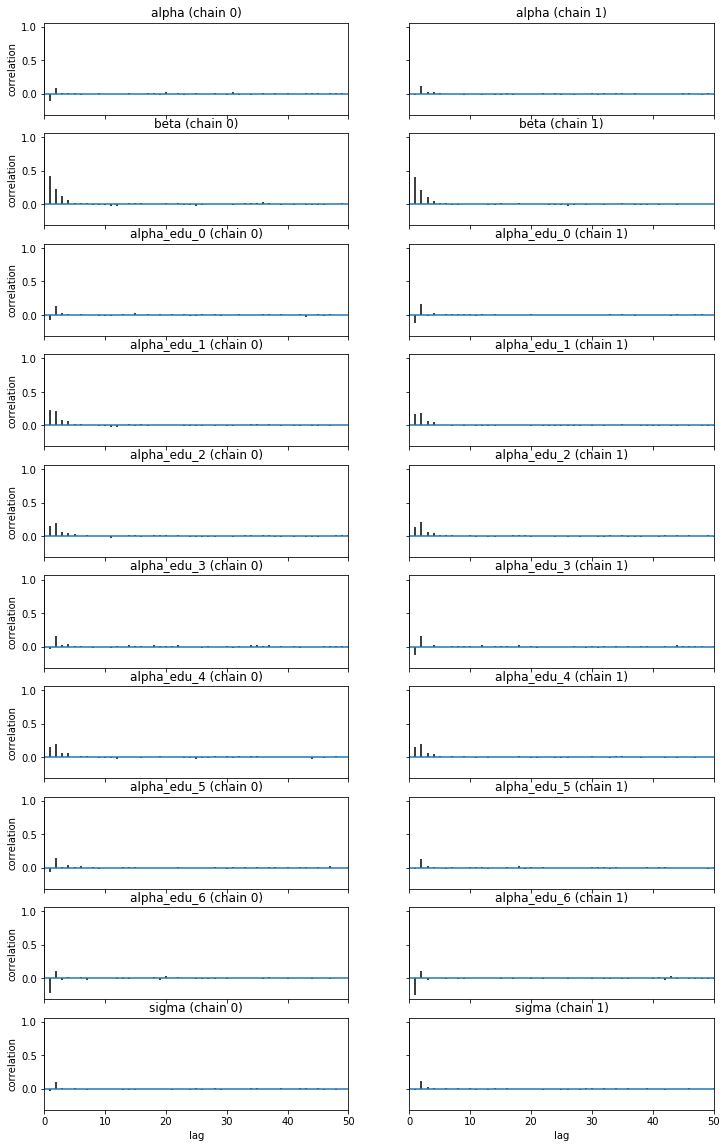

In [6]:
pm.autocorrplot(t1a, max_lag=50);

Autocorrelations are dying very quickly (no more than lag 10) for all parameters in all chains.

#### Parameter trace correlation

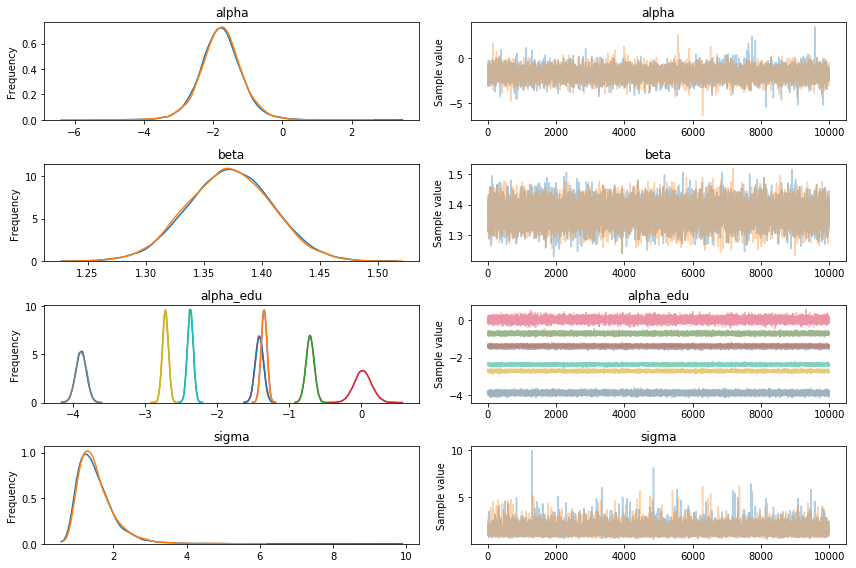

In [7]:
pm.traceplot(t1a);

Traces in different chains are consistent, and traces look like white noises. The result indicates the convergence of parameters.

#### Gelman-Rubin

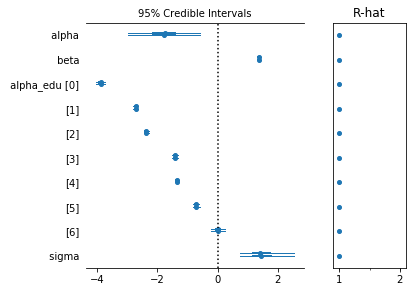

In [8]:
pm.forestplot(t1a);

The values of $\hat{R}$ are very close to 1 for all parameters, which is good.

#### Number of Effective Samples ($n_{eff}$)

In [9]:
print('Effective sample sizes')
print(pm.effective_n(t1a))

Effective sample sizes
{'alpha': 17013.0, 'beta': 7325.0, 'alpha_edu': array([16549.,  9242., 10023., 15856., 10073., 14890., 20000.]), 'sigma': 16293.0}


The number of effective samples are high for most parameters and >20% for all parameters.

The above tests show the quality of samples we obtained is OK.

### Answer to Q1 A4

In [10]:
p1a = np.concatenate((t1a['alpha_edu'], t1a['alpha_edu'] + t1a['beta'].reshape(-1, 1)), axis=1)

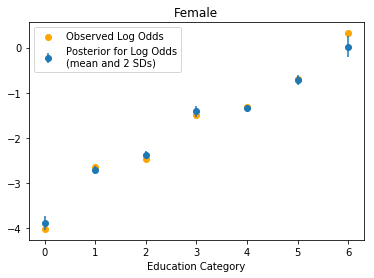

In [11]:
d = dataset[dataset.sex==0]
shrinkage_plot(logit(d['>50'] / d['total']), t1a['alpha_edu'].mean(axis=0), t1a['alpha_edu'].std(axis=0))
plt.title('Female');

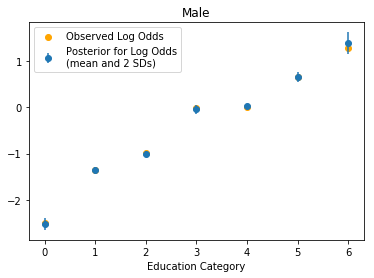

In [12]:
d = dataset[dataset.sex==1]
shrinkage_plot(logit(d['>50'] / d['total']), (t1a['alpha_edu'] + t1a['beta'].reshape(-1, 1)).mean(axis=0), \
               (t1a['alpha_edu'] + t1a['beta'].reshape(-1, 1)).std(axis=0))
plt.title('Male');

We're interested in the $\alpha$ shrinkage. So we should look at either male or female (female would be better since we take out the effect of $\beta$, anyway we plot figures for both genders). Except for the last category, we see minimal shrinkage as said in the question.

### Answer to Q1 A5
The model shows very minimal shrinkage because nearly all education categories, except the last education category, have more samples (total counts) than McElreath's UCB admission dataset by department, and as a result the data likelihood overwhelms the prior. For the last education category, the total counts is smaller, and the standard error of posterior is larger; as a result, there is more shrinkage for the last category.

For any individual, getting an annual income above or below 50k is a bernoulli distribution. We can think individual income level at given education/gender category as i.i.d bernoulli distribution and by central limit theorem, their mean (p) will be a normal with variance $\frac{p(1-p)}{n}$. The standard error would be $\sqrt{\frac{p(1-p)}{n}}$. When we have a large $n$, we will get less standard error and less shrinkage.

## Part B: Iterating further

After the pooling model above, McElreath builds a model where the alpha and beta in each unit might be correlated (perhaps the higher the admission rate, the less bias there is towards either gender). 

**B1**: Implement the model in 13.2.2. Feel free to use [code from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb) with attribution and understanding (it contains some sweet pymc3 technical wrangling).

The variable names in this model are unchanged and you may re-name them if you wish.

Note that this model builds the a 7 by 2 matrix with alpha values in the first column and beta values in the second. By assumption, the first column and the second column have correlation structure given by the LKJ prior, but there is no explicit correlation among the rows (aside from all the alphas coming from the same mean). In other words, the correlation matrix is 2x2 (not 14x14) and amongst the income-level-free parts of the intercept and slope.

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes 10 minutes per chain on a VM on old hardware and 2 minutes 30 seconds on a recent-gen Mac). Analyze at least two diagnostics and comment on the quality of the samples obtained.

**B3**: Propose at least two methods of improving the quality of the samples obtained and explain how/why each method would help. For **some extra credit** implement these. 

**B4**: Regardless of your answer above, assume the samples are valid and give an analysis of whether the data and models support the hypothesis that males are more advantaged in lower income categories than they are in higher income categories. For full credit, include at least one formal model comparison or probability analysis.

**B5**: Regardless of your answer above, assume the samples are valid and give an analysis of: 
1. The posterior probability that males with a Bachelor's degree are more likely to have high incomes than males with a Professional School degree (education categories 3 and 4) \[Specifically, how certain is it that one or the other class has a higher chance of having a high income?\]. 
2. The posterior-predictive on the number of female PhDs earning more than 50K in similarly sized samples

### Answer to Q1 B1

In [13]:
# Reference: https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb
# Code 13.19

with pm.Model() as m1b:
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = T.dot(chol, chol.T)
    
    sigma_ab = pm.Deterministic('sigma_edu', T.sqrt(T.diag(cov)))
    corr = T.diag(sigma_ab**-1).dot(cov.dot(T.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('ab_cafe', mu=T.stack([alpha, beta]), chol=chol, shape=(len(dataset['category'].unique()), 2))
    
    alpha_edu = pm.Deterministic('alpha_edu', mu[:, 0])
    beta_edu = pm.Deterministic('beta_edu', mu[:, 1])
    
    p = pm.Deterministic('p', \
                         pm.math.invlogit(mu[dataset['category'], 0] + mu[dataset['category'], 1] * dataset['sex']))
    y_obs = pm.Binomial('y_obs', p=p, n=dataset['total'], observed=dataset['>50'])

### Answer to Q1 B2

In [14]:
%%time

with m1b:
    t1b = pm.sample(10000, tune=2000, step=pm.NUTS(target_accept=0.95))

/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_cafe, chol_cov_cholesky_cov_packed__, beta, alpha]
100%|██████████| 12000/12000 [06:07<00:00, 32.69it/s]
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 3.53 s, sys: 989 ms, total: 4.52 s
Wall time: 6min 13s


We see a lot of warnings in PyMC sampling. Below, we check the sample quality.

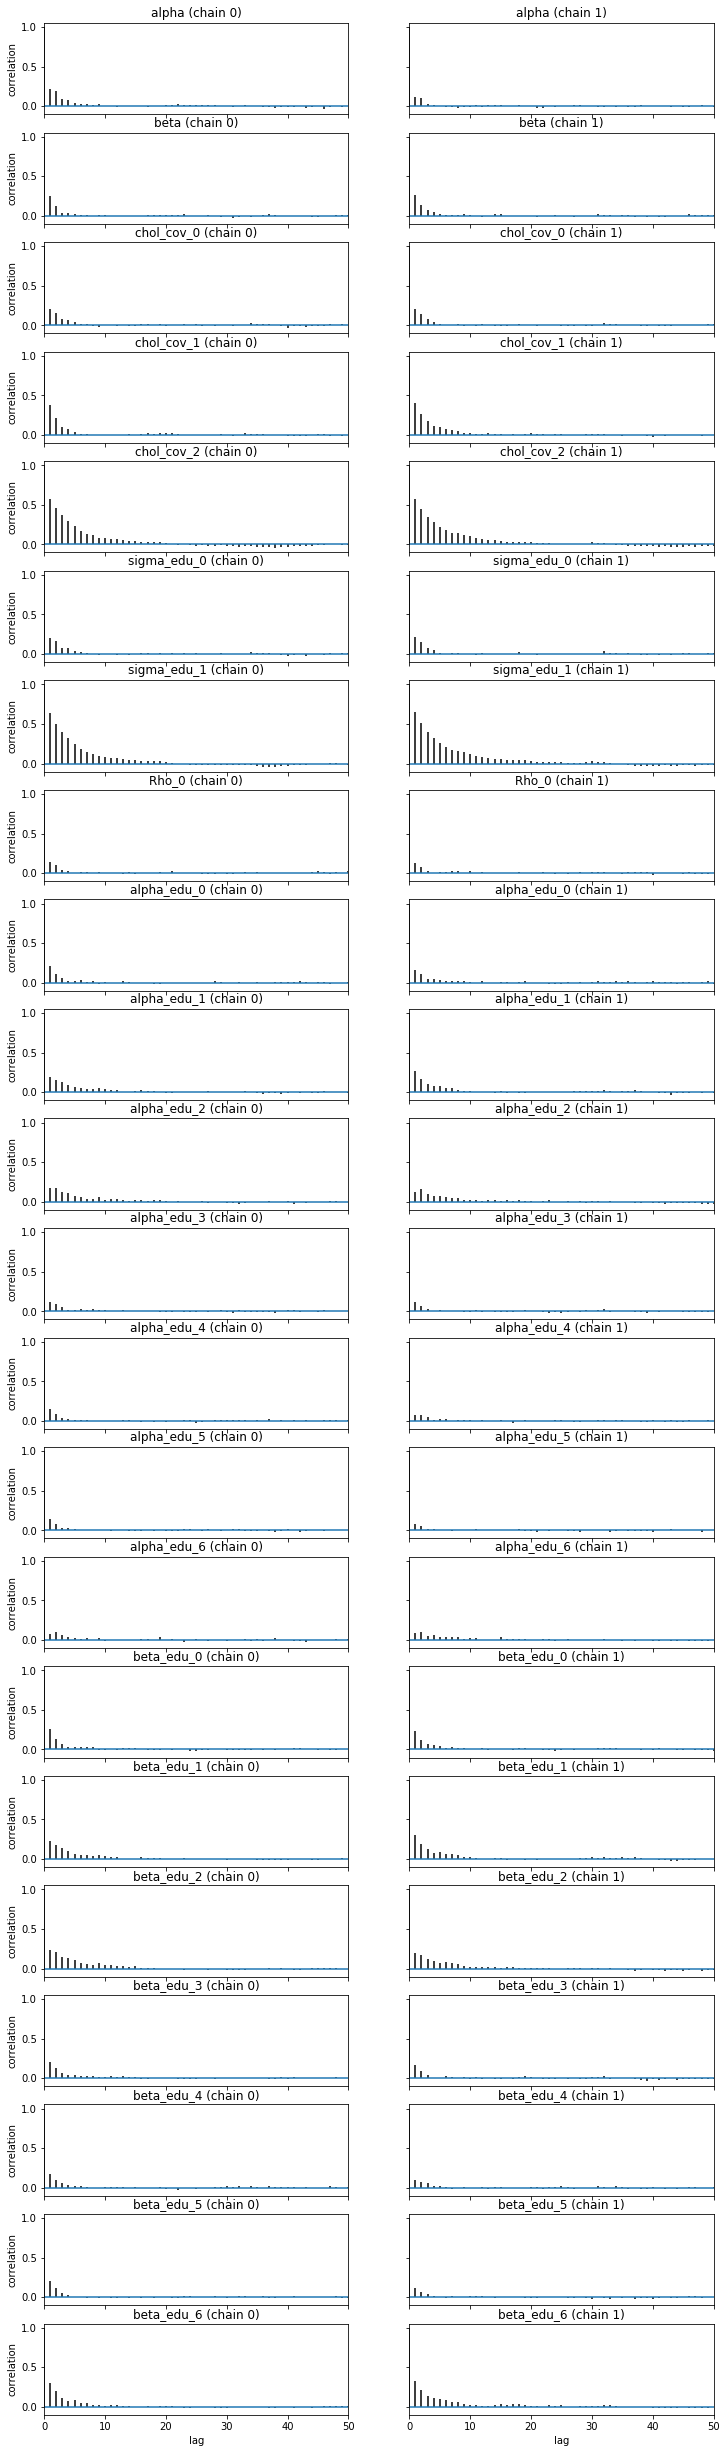

In [15]:
pm.autocorrplot(t1b, max_lag=50, varnames=['alpha', 'beta', 'chol_cov', 'sigma_edu', 'Rho', 'alpha_edu', 
                                           'beta_edu']);

Autocorrelations for some parameters are large.

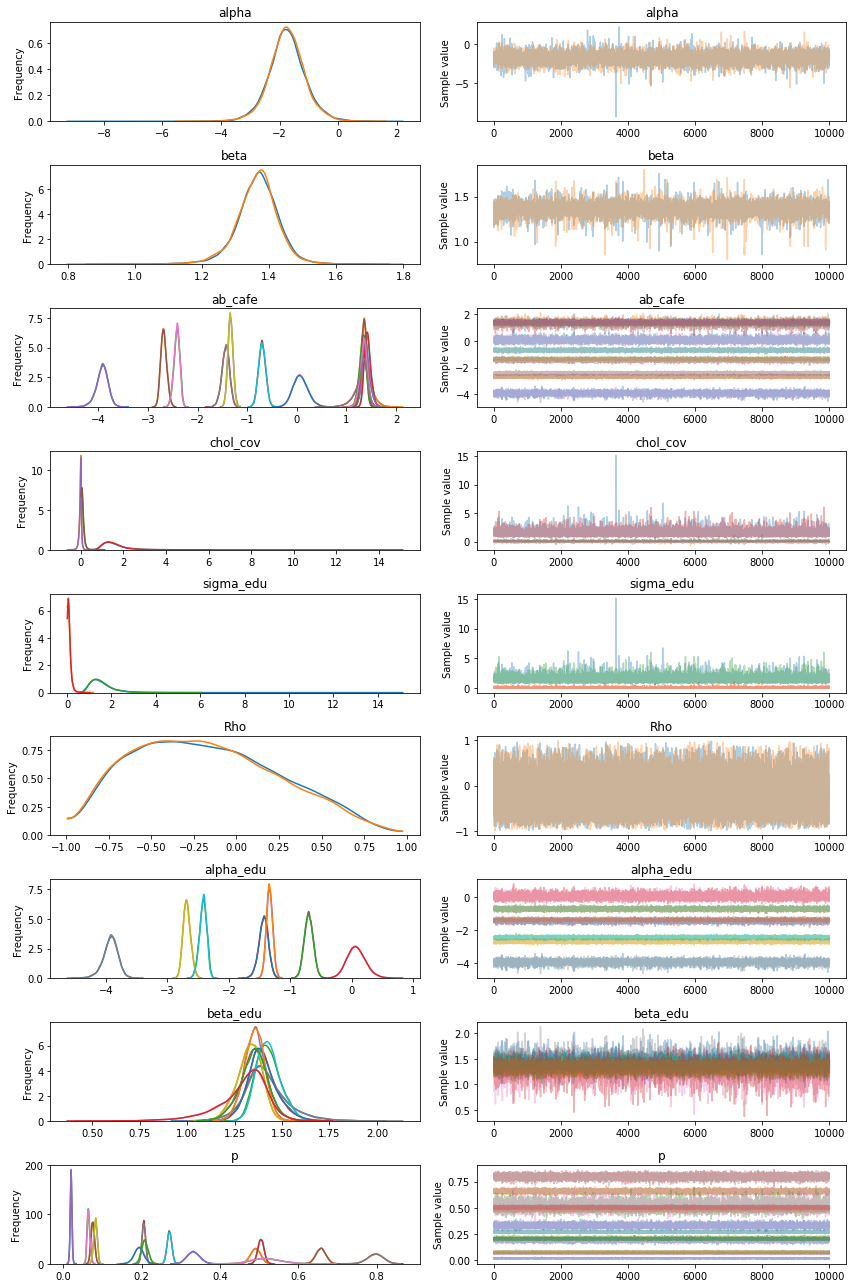

In [16]:
pm.traceplot(t1b);

Traces in different chains are not consistent for some parameters, and traces look like white noises. So the quality of samples is not good.

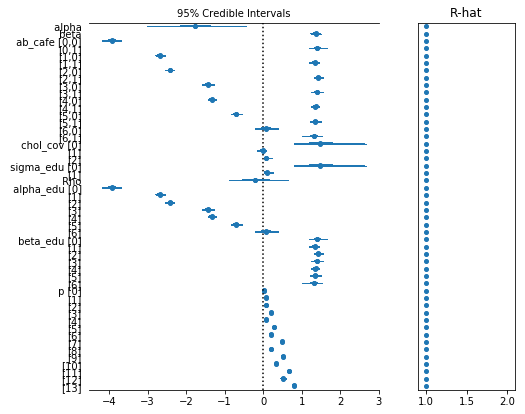

In [17]:
plt.figure(figsize=(8, 6))
pm.forestplot(t1b);

The values of $\hat{R}$ are very close to 1 for all parameters, which is good.

In [18]:
print('Effective sample sizes')
print(pm.effective_n(t1b))

Effective sample sizes
{'alpha': 10217.0, 'beta': 9459.0, 'ab_cafe': array([[ 9923.,  8682.],
       [ 7122.,  6424.],
       [ 6751.,  5904.],
       [12014.,  9940.],
       [12397., 11839.],
       [12893., 12029.],
       [10687.,  5796.]]), 'chol_cov': array([9418., 5943., 2859.]), 'sigma_edu': array([9418., 2589.]), 'Rho': array([11690.]), 'alpha_edu': array([ 9923.,  7122.,  6751., 12014., 12397., 12893., 10687.]), 'beta_edu': array([ 8682.,  6424.,  5904.,  9940., 11839., 12029.,  5796.]), 'p': array([10593., 20000.,  7105., 20000.,  6780., 15682., 12226., 20000.,
       12352., 20000., 12876., 20000., 10725., 20000.])}


The number of effective samples is very low for some parameters.

We notice the quality of samples varies when we run the model for multiple times. As suggested by the above test, the quality of the samples is poor in this run; and sometimes there are much more divergences, and the quality of samples can be much worse.

### Answer to Q1 B3

As suggested by `pymc3`, we can increase `target_accept` or reparameterize (non-cencered parameterization).

#### Increase target acceptance rate

We are using NUTS (No-U-Turn Sampler), which automatically tunes the step size and the number of steps per sample. According to the [documentation](http://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts) of NUTS, `target_accept` adapts the step size such that the average acceptance probability across the trajectories are close to `target_accept`. Higher `target_accept` would lead to smaller step sizes, and thus reasonable symplectic integrations. By increasing `target_accept`, we would be more likely to have geometric ergodicity between the Hamiltonian transitions and the target distribution; as a result, the divergence rate would decrease.

References:  
https://am207.github.io/2018spring/wiki/hmctweaking.html#tracking-divergences  
http://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts

The implementation is as follows:

In [19]:
%%time

with m1b:
    t1b_2 = pm.sample(10000, tune=2000, step=pm.NUTS(target_accept=0.99))

/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab_cafe, chol_cov_cholesky_cov_packed__, beta, alpha]
100%|██████████| 12000/12000 [11:21<00:00, 17.60it/s]
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9709308998295277, but should be close to 0.99. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 4.56 s, sys: 1.36 s, total: 5.92 s
Wall time: 15min 47s


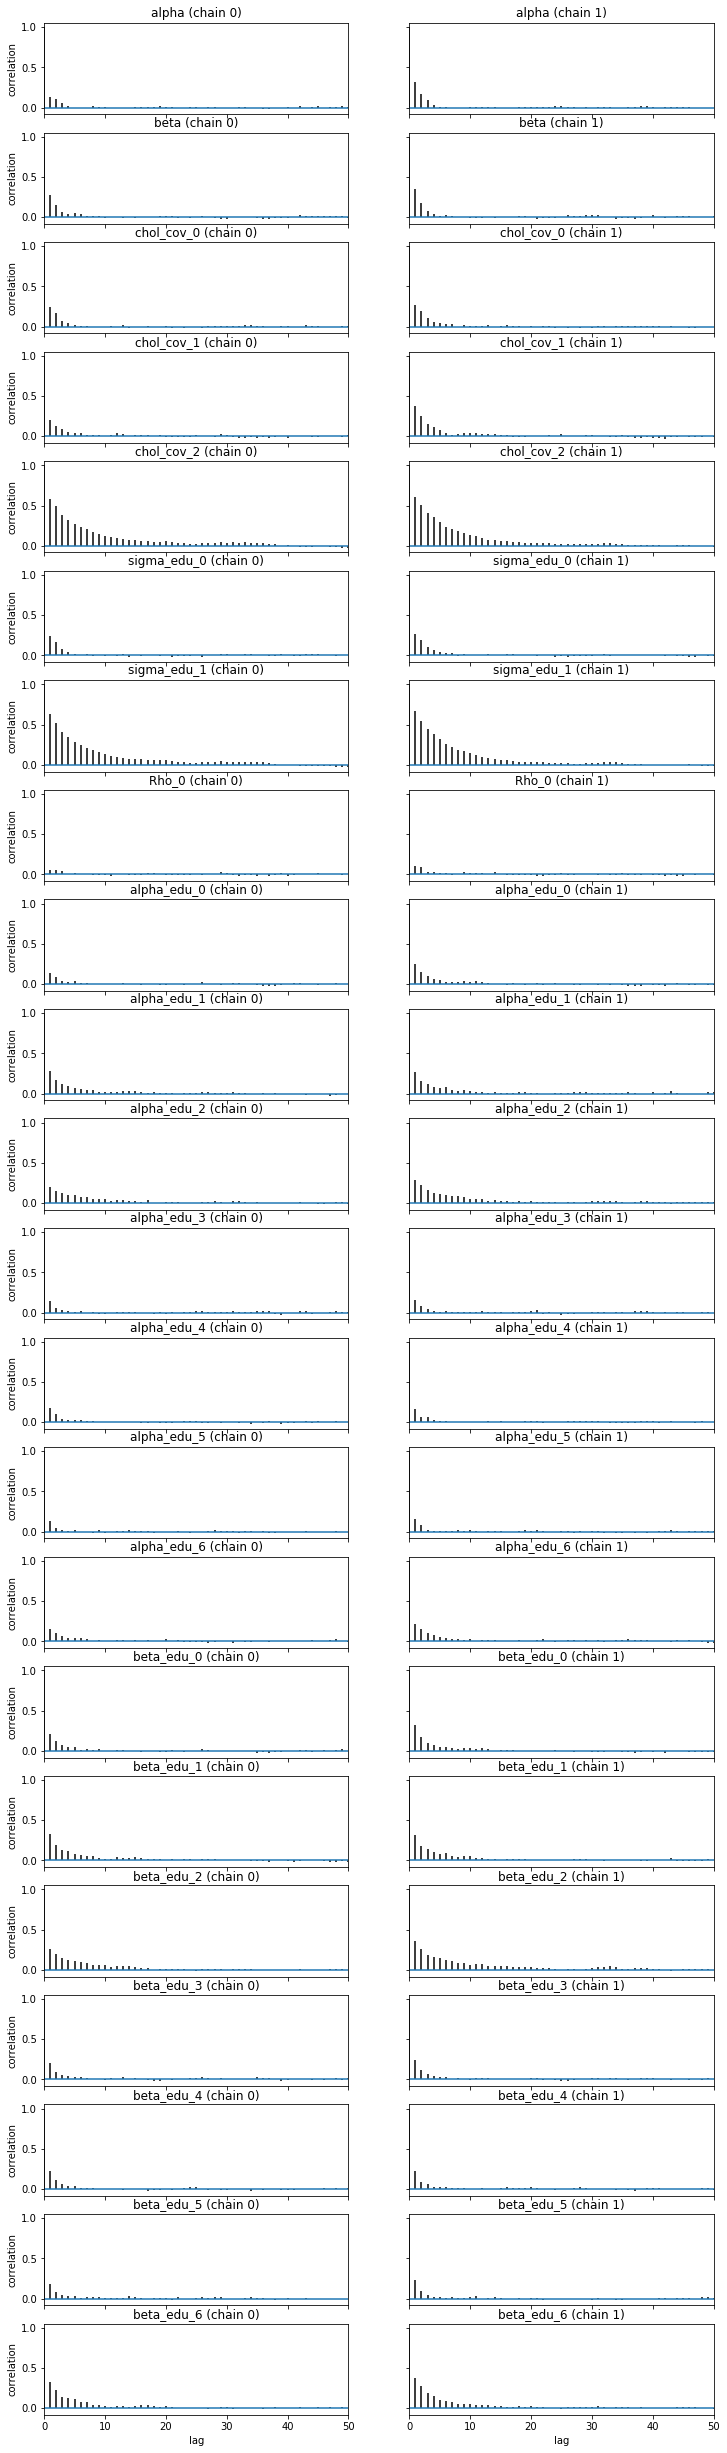

In [20]:
pm.autocorrplot(t1b_2, max_lag=50, varnames=['alpha', 'beta', 'chol_cov', 'sigma_edu', 'Rho', 'alpha_edu', 
                                             'beta_edu']);

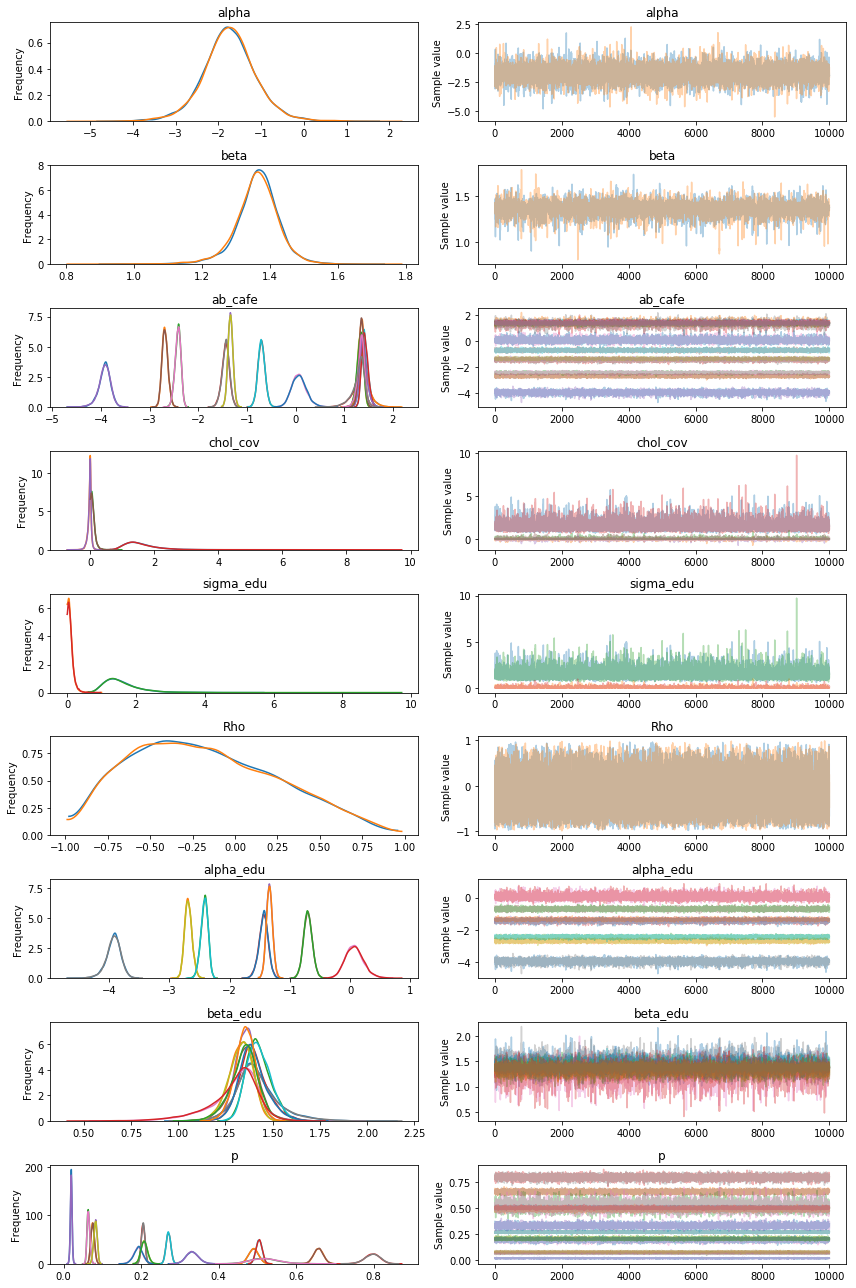

In [21]:
pm.traceplot(t1b_2);

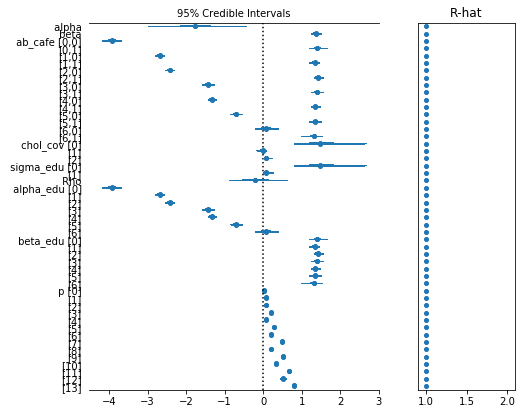

In [22]:
plt.figure(figsize=(8, 6))
pm.forestplot(t1b_2);

In [23]:
print('Effective sample sizes')
print(pm.effective_n(t1b_2))

Effective sample sizes
{'alpha': 9374.0, 'beta': 8491.0, 'ab_cafe': array([[ 8984.,  7776.],
       [ 5843.,  5202.],
       [ 4652.,  3892.],
       [12072.,  9145.],
       [10877.,  9689.],
       [11884.,  9638.],
       [ 8018.,  4800.]]), 'chol_cov': array([8556., 6561., 2112.]), 'sigma_edu': array([8556., 2020.]), 'Rho': array([12694.]), 'alpha_edu': array([ 8984.,  5843.,  4652., 12072., 10877., 11884.,  8018.]), 'beta_edu': array([7776., 5202., 3892., 9145., 9689., 9638., 4800.]), 'p': array([ 9755., 20000.,  5803., 20000.,  4659., 20000., 12204., 20000.,
       10838., 20000., 11839., 20000.,  8037., 20000.])}


The resulting parameter distributions are similar to the previous case, but the quality of samples is significantly improved, as suggested by less divergences, less autocorrelations and higher effective sample sizes.

#### Non-centered parameterization

We can reparameterize the model to use a non-centered parameterization for the multivariate Gaussian varying effects prior, i.e., to use a standardized adaptive prior for the varying effects. Specifically, we can reparameterize the model as follows:

$$y_i \sim \text{Binomial}(n_i, p_i)$$
$$\text{logit}(p_i) = \alpha_{edu[i]}+\beta_{edu[i]}m_i$$
$$\alpha_{edu[i]}=a+N(0,1)\sigma_1$$
$$\beta_{edu[i]}=bm+N(0,1)\sigma_2$$

The non-centered parameterization would reduce steepness and curvature, making for better stepping. It would also reduce the strong change in densities, and makes sampling from the transition distribution easier. 

References:  
https://am207.github.io/2018spring/wiki/gelmanschools.html#non-centered-model  
http://xcelab.net/rm/statistical-rethinking/

The implementation is as follows:

In [24]:
# Code 3.19 and 3.23
# of https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb
with pm.Model() as m1b_NC:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    
    #Non-centered parameterization
    mu_chol_b = pm.Normal('mu_chol_b', 0., 1., shape=(7,2))
    mu = T.stack([a,bm])+T.dot(mu_chol_b,chol)
    
    pm.Deterministic('alpha_edu', mu[:, 0])
    pm.Deterministic('beta_edu', mu[:, 1])
    
    p = pm.Deterministic('p', pm.math.invlogit(mu[np.arange(14)//2,0] + mu[np.arange(14)//2,1] * dataset['sex']))
    y = pm.Binomial('y_obs', p=p, n=dataset['total'], observed=dataset['>50'])

In [25]:
%%time

with m1b_NC:
    t1b_NC = pm.sample(10000, tune=2000, step=pm.NUTS(target_accept=0.99))

/usr/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_chol_b, chol_cov_cholesky_cov_packed__, bm, a]
100%|██████████| 12000/12000 [38:03<00:00,  5.25it/s]
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 7.28 s, sys: 3.37 s, total: 10.7 s
Wall time: 40min 58s


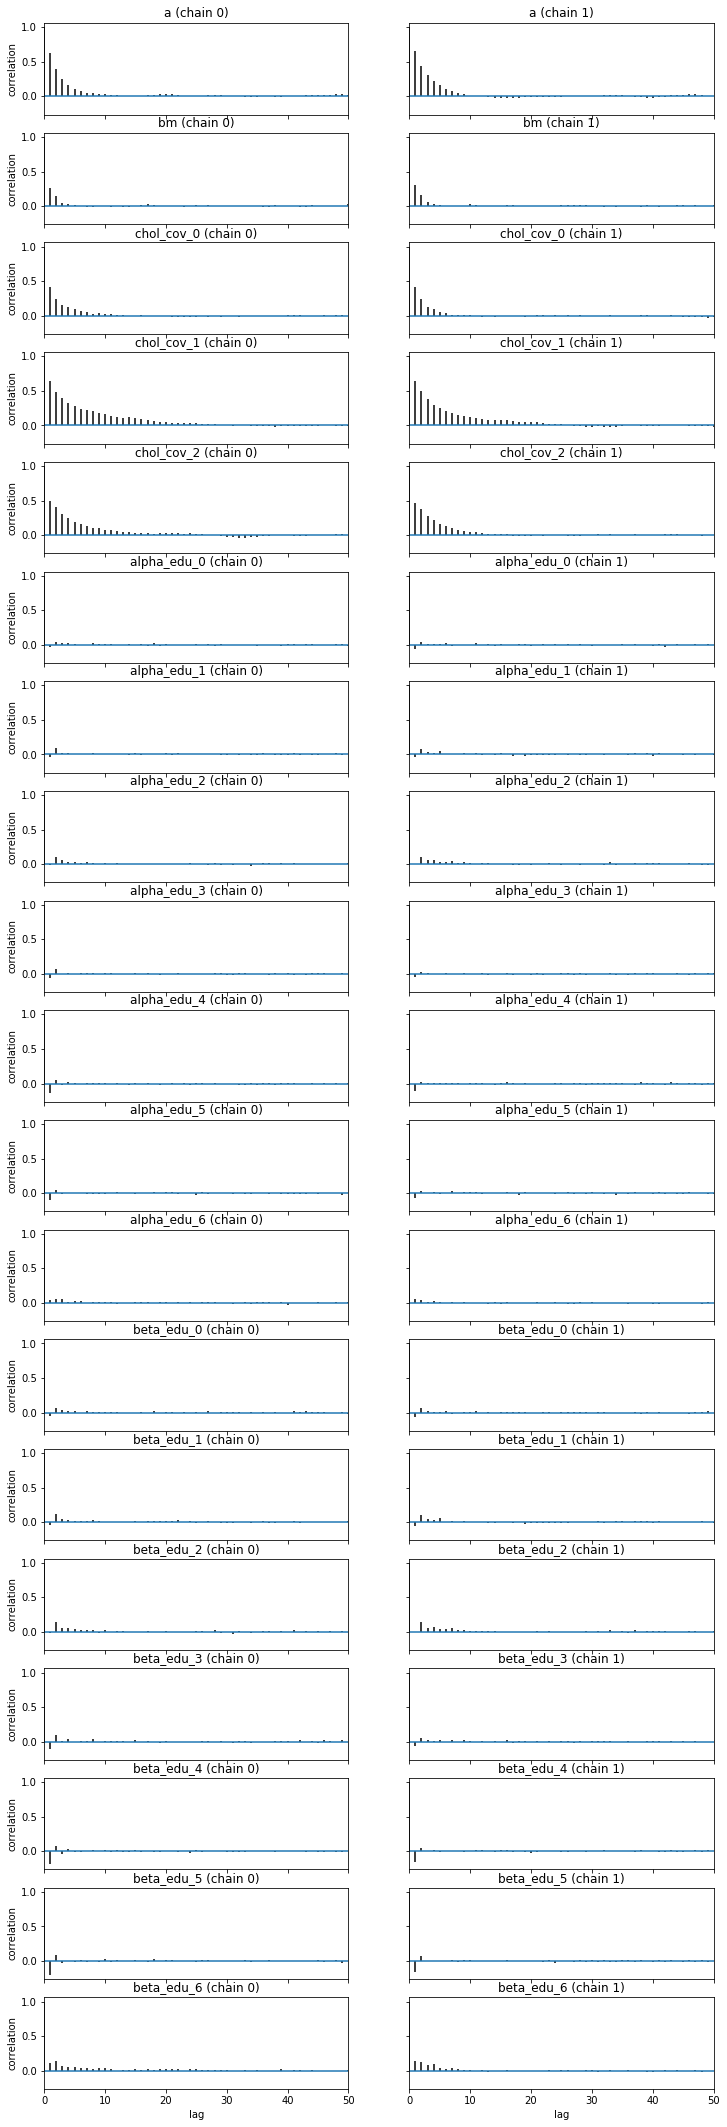

In [26]:
pm.autocorrplot(t1b_NC, max_lag=50, varnames=['a', 'bm', 'chol_cov', 'alpha_edu', 'beta_edu']);

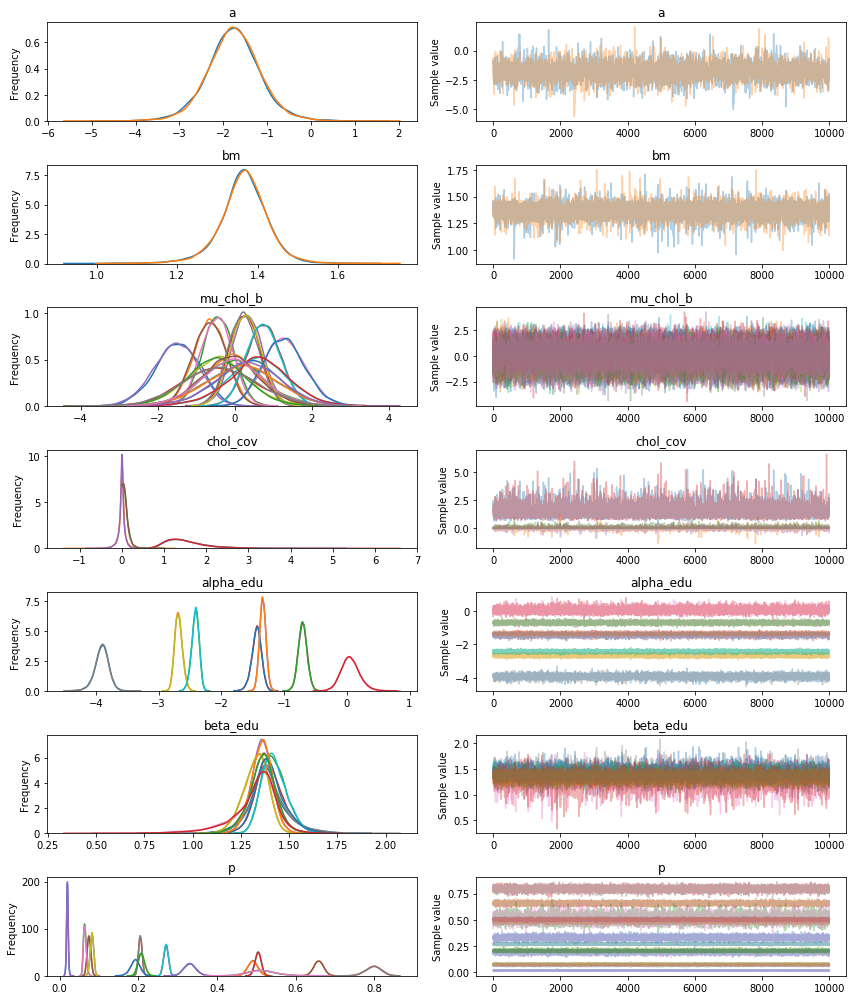

In [27]:
pm.traceplot(t1b_NC);

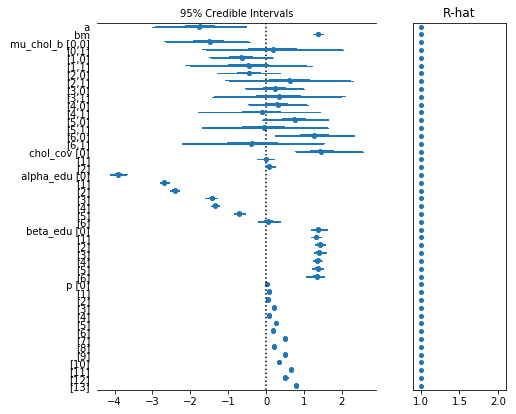

In [28]:
plt.figure(figsize=(8, 6))
pm.forestplot(t1b_NC);

In [29]:
print('Effective sample sizes')
print(pm.effective_n(t1b_NC))

Effective sample sizes
{'a': 4073.0, 'bm': 9755.0, 'mu_chol_b': array([[ 5096., 20000.],
       [ 4517., 14306.],
       [ 4263., 14158.],
       [ 4062., 14974.],
       [ 4099., 15369.],
       [ 4237., 20000.],
       [ 4655., 16926.]]), 'chol_cov': array([6092., 2192., 3492.]), 'alpha_edu': array([20000., 14155., 11437., 20000., 20000., 20000., 14048.]), 'beta_edu': array([16313., 13292., 10331., 20000., 20000., 20000.,  8917.]), 'p': array([20000., 19970., 14205., 18823., 11441., 16222., 20000., 19915.,
       20000., 20000., 20000., 20000., 14098., 19447.])}


As we can see, the quality of samples has further improved (should look at `alpha_edu` and `beta_edu` the number of effective samples increases).

We use the result of the model with non-centered parameterization for B4 and B5.

### Answer to Q1 B4

We can first check the posterior distribution of $\beta_{edu}$.

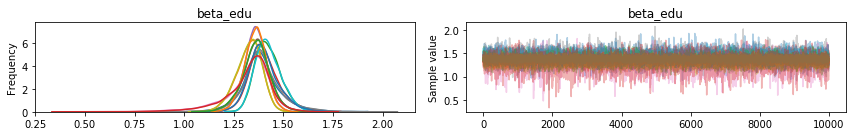

In [30]:
pm.traceplot(t1b_NC, varnames=['beta_edu']);

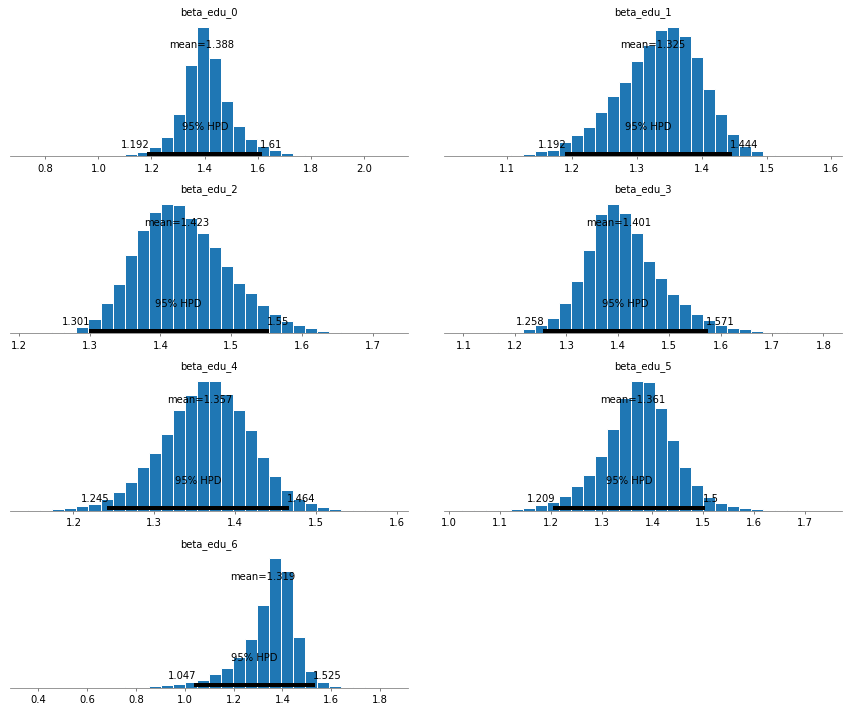

In [31]:
pm.plot_posterior(t1b_NC, varnames=['beta_edu']);

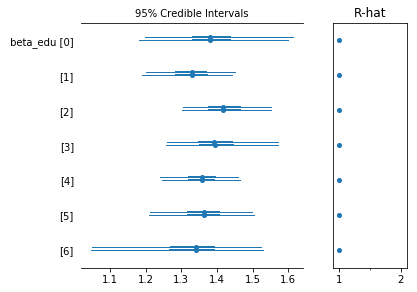

In [32]:
pm.forestplot(t1b_NC, varnames=['beta_edu']);

In [33]:
pm.summary(t1b_NC, varnames=['beta_edu'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_edu__0,1.388273,0.099994,0.000889,1.191803,1.610131,16313.0,0.999980
beta_edu__1,1.325179,0.064870,0.000620,1.192001,1.443701,13292.0,0.999953
beta_edu__2,1.423092,0.064659,0.000694,1.301317,1.550386,10331.0,0.999950
beta_edu__3,1.400866,0.078225,0.000631,1.258049,1.571469,20000.0,0.999952
beta_edu__4,1.356687,0.055500,0.000349,1.244601,1.464133,20000.0,0.999955
beta_edu__5,1.360676,0.071532,0.000457,1.208823,1.499992,20000.0,0.999959
beta_edu__6,1.318715,0.120821,0.001313,1.046526,1.525083,8917.0,1.000100


Intuitively, the distributions of $\beta_{edu}$ overlap with each other, which goes against the hypothesis (although males in lower income categories show very limited advantages than males in higher income categories).

We can compare the model with the model in Part A to see whether it is necessary to allow $\beta_{edu}$ to vary across different education categories.

In [34]:
def compare_models(names, traces, models):
    df = pm.compare(traces, models, method='pseudo-BMA')
    df = df.sort_index()
    df.insert(loc=0, column='name', value=names)
    df = df.sort_values('WAIC')
    df = df.set_index('name')
    return df

compare_df = compare_models(['model A', 'model B'], [t1a, t1b_NC], [m1a, m1b_NC])
compare_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
name,,,,,,,
model B,122.1,6.31,0,0.67,4.83,0,1
model A,123.56,6.24,1.45,0.33,5.71,1.5,1


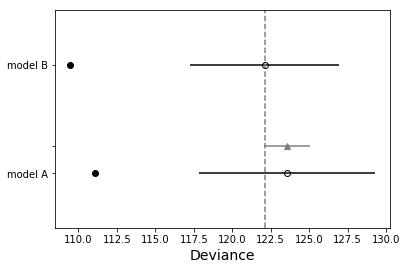

In [35]:
pm.compareplot(compare_df);

As we can see (via pWAIC), the number of estimated model parameters for 2 models is similar, suggesting it is unnecessary to use different $\beta_{edu}$ for different categories. Model A (single $\beta_{edu}$) is slightly preferred than model B (varying $\beta_{edu}$), and dWAIC is much smaller than SE, which further suggests that it is not necessary to use varying $\beta_{edu}$.

In conclusion, the data and models don't support the hypothesis that males are more advantaged in lower income categories than they are in higher income categories.

### Answer to Q1 B5
#### Answer to Q1 B5.1

In [36]:
p_male = t1b_NC['alpha_edu'] + t1b_NC['beta_edu']
print('''The posterior probability that males with a Bachelor\'s degree are more likely to 
have high incomes than males with a Professional School degree:''')
print(np.mean(p_male[:, 4] > p_male[:, 3]))

The posterior probability that males with a Bachelor's degree are more likely to 
have high incomes than males with a Professional School degree:
0.823


#### Answer to Q1 B5.2

In [37]:
%%time

with m1b_NC:
    ppc2 = pm.sample_ppc(t1b_NC)

100%|██████████| 10000/10000 [00:04<00:00, 2064.81it/s]

CPU times: user 4.81 s, sys: 28.5 ms, total: 4.84 s
Wall time: 4.85 s


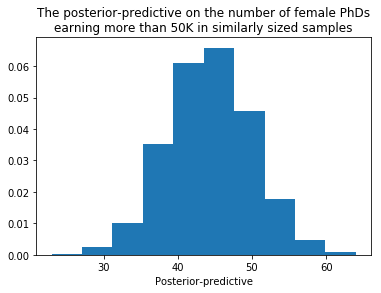

In [38]:
plt.hist(ppc2['y_obs'][:, -2], normed=True);
plt.xlabel('Posterior-predictive');
plt.title('''The posterior-predictive on the number of female PhDs
earning more than 50K in similarly sized samples''');

In [39]:
print('The number of female PhDs earning more than 50K in similarly sized samples')
print('Posterior-predictive mean: {}'.format(np.mean(ppc2['y_obs'][:, -2])))
print('Posterior-predictive HPD ([2.5% HPD, 97.5% HPD]): {}'.format(pm.stats.hpd(ppc2['y_obs'][:, -2])))

The number of female PhDs earning more than 50K in similarly sized samples
Posterior-predictive mean: 44.2647
Posterior-predictive HPD ([2.5% HPD, 97.5% HPD]): [34 55]


# Q2: Using Mixture of Experts and Mixture Density Networks to Solve Inverse Problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail.

We read this data in...

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv("one-to-many.csv")
print(len(df))
df.head()

1000


,target,x
0,0.000000,0.018727
1,0.001001,0.050424
2,0.002002,0.042375
3,0.003003,0.038596
4,0.004004,0.019352


...and then plot it. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

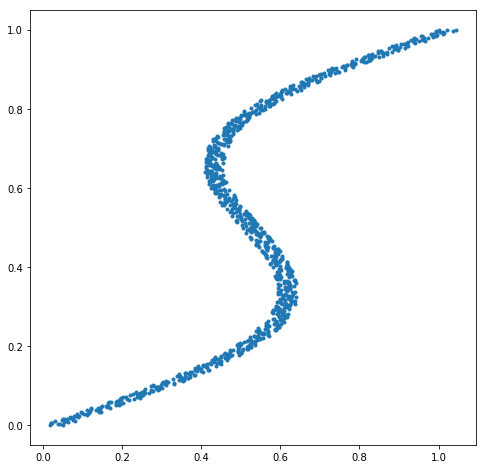

In [41]:
X_train, y_train = df.x.values, df.target.values

plt.figure(figsize=(8, 8))
plt.plot(df.x, df.target, '.');

Normal regression approaches to modeling such a function wont work, as they expect the function to be a proper mathematical function, that is, single valued.

These kind of problems are called **inverse problems**, where more than one input state leads to an output state, and we have to try and model these multiple input states.

A mixture of gaussians (or other distributions) might is a sensible way to do this.

You choose one of the gaussians with some probability. The nean of the gaussian is then given by some regression function, say for example a straight line. We could additionally fix the standard deviation or model it as well. 

Thus, for each component Gaussian, we choose a functional form for the mean and standard deviation. So our model looks something like this:

$$f(x)  = \sum_i \lambda_i g_i (x) $$

Say we fit a model with 3 gaussians to this data. Such a model cannot fit the function above. Notice for example that at $x=0.2$ only one of the gaussians will dominate, different from the situation at $x=0.5$. This means that the probabilities of "belonging" to one or the other gaussians is also changing with $x$.

If we allow the mixing probabilities to depend on $x$, we can model this situation.

$$f(x)  = \sum_i \lambda_i (x) g_i (x) $$

Such a model is called a "mixture of experts" model. The idea is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector.

You can think of this model as implementing a "standard" gaussian mixture at each "point" x, with the added complexity that all of the means, standard deviations, and mixture probabilities change from one x to another.

See https://www.cs.toronto.edu/~hinton/absps/hme.pdf and http://www.ee.hacettepe.edu.tr/~eyuksel/Publications/2012_TwentyYearsofMixtureofExperts.pdf for more details. I found the latter clearer and easier to understand.

For this entire question you might find diagram code from [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) useful. Take with attribution.

We will assume we have **3 gaussians**.

## PART A: Iterative Linear Regression

The basic idea, illustrated below, is to fit piecewise linear regressions iteratively in a EM style algorithm.

![](images/mixreg0.png)

The algorithm looks like this: initialize the 1000 points in this dataset as randomly belonging to one of 3 "classes" or "clusters" or "experts". This takes a x-data problem and augments it with a fake z data point that tells us whether the point belongs in cluster 0, 1, or 2. (It helps convergence to say that points in the leftmost 0.2 belong to cluster 0 and righmost 0.2 to cluster 2).

Once we have the fake z data we can separate out the 1000 points into 3 sets of points and fit 3 linear regression models. 

We can make predictions for all 1000 points on the data for each of the 3 regression lines. We now assign a data point to the cluster by calculating the squared distances between its actual y value and the 3 cluster predictions and choosing the smallest one.

We then rinse and repeat.

**A1** Implement this algorithm along with a convergence criterion of your choice

**A2** Produce a diagram like the one above which illustrates the straight line fits as well as the cluster belonging. 


### Answer to Q2 A1

E-step: assign points to clusters.

M-step: re-calculate the regression lines.

I use sklearn to fit the OLS. The implementation is below. For initialization, I assign the leftmost 0.2 to cluster 0 and rightmost 0.2 to cluster2. All other points are assigned to cluster 1.

I set convergence criterion as **no point changes the cluster assignment from last iteration**.

In [42]:
from sklearn.linear_model import LinearRegression

def update_assignment(df,line_coef=None):
    assign_list = []
    for y,x in df.values:
        if type(line_coef)==type(None):
            # initialize
            if x<0.2:
                assign_list.append(0)
            elif x>0.8:
                assign_list.append(2)
            else:
                assign_list.append(1)
        else:
            y0 = line_coef[0]*x+line_coef[1]
            y1 = line_coef[2]*x+line_coef[3]
            y2 = line_coef[4]*x+line_coef[5]
            # get smallest cluster idx.
            assign_list.append(np.argmin(np.square(np.array([y0,y1,y2])-y)))
    return np.array(assign_list)
    
def make_clusters(points_assignment,df):
    clusters = [[],[],[]]
    for idx,(y,x) in enumerate(df.values):
        clusters[points_assignment[idx]].append([x,y])
    return clusters

def calc_regression(clusters):
    result = []
    for cluster in clusters:
        cluster = np.array(cluster)
        lr = LinearRegression()
        lr.fit(cluster[:,0].reshape(-1,1),cluster[:,1])
        result.append(lr.coef_[0])
        result.append(lr.intercept_)
    return np.array(result)

line_coef=None
old_assignment=None
while True:
    assignment = update_assignment(df,line_coef)
    # check convergence
    if all(assignment==old_assignment):
        break
    old_assignment=assignment
    clusters = make_clusters(assignment,df)
    line_coef = calc_regression(clusters)

### Answer to Q2 A2

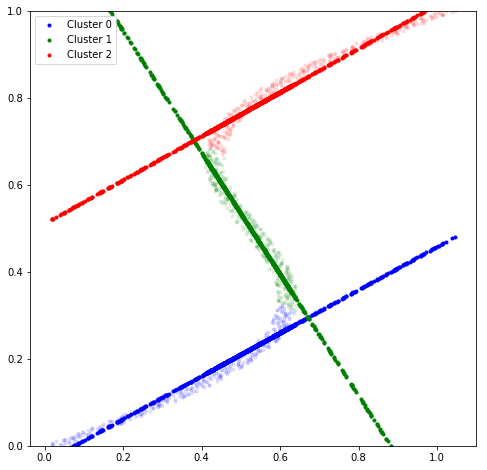

In [43]:
plt.figure(figsize=(8,8))
# plot cluster belongings
plt.scatter(np.array(clusters[0])[:,0],np.array(clusters[0])[:,1],c='b',marker='.',alpha=0.1)
plt.scatter(np.array(clusters[1])[:,0],np.array(clusters[1])[:,1],c='g',marker='.',alpha=0.1)
plt.scatter(np.array(clusters[2])[:,0],np.array(clusters[2])[:,1],c='r',marker='.',alpha=0.1)

#plot line
plot_x = df.x.values
plt.scatter(plot_x,line_coef[0]*plot_x+line_coef[1],color='b',marker='.',label='Cluster 0')
plt.scatter(plot_x,line_coef[2]*plot_x+line_coef[3],color='g',marker='.',label='Cluster 1')
plt.scatter(plot_x,line_coef[4]*plot_x+line_coef[5],color='r',marker='.',label='Cluster 2')
plt.ylim((0,1))
plt.legend()
plt.show()

## Part B: Variational Mixture of Experts

In this part we'll construct a gaussian mixture model of 3 "expert" linear regressions. The idea is to create a fit which looks like this:

![](images/mixreg.png)

Here again the three regression lines work in different regions of $f$. We want a principled way to sample from this model and to be able to produce posterior and posterior-predictive regions.

There are 3 parts to this model. First the means of the gaussians in the mixture are modeled with linear regression as shown in the picture above. We will also model $log(\sigma)$ for each gaussian in the mixture as a linear regression as well ($\sigma$ needs to be positive).

We now need to model the mixture probabilities, i.e., the probabilities required to choose one or the other gaussian. We'll model these probabilities i.e. the $\lambda$s using softmax regression (ie do a linear regression and softmax it to get 3 probabilities).

**B1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

**B2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

**B3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the means with standard deviations showing their uncertainty overlaid on the data.

**B4** Plot the posterior predictive (mean and variance) as a function of x for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

**B5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. This diagram may look something like this:

![](images/mixpred.png)

### Answer to Q2 B1

In [44]:
n_gaussians = 3
X_shared = shared(X_train.reshape(-1, 1), broadcastable=[False, True])

with pm.Model() as m2b:
    alpha_pi = pm.Normal('alpha_pi', 0, 5, shape=n_gaussians)
    beta_pi = pm.Normal('beta_pi', 0, 5, shape=n_gaussians)
    
    alpha_mu = pm.Normal('alpha_mu', 0, 5, shape=n_gaussians)
    beta_mu = pm.Normal('beta_mu', 0, 5, shape=n_gaussians)
    
    alpha_logsigma = pm.Normal('alpha_logsigma', 0, 5, shape=n_gaussians)
    beta_logsigma = pm.Normal('beta_logsigma', 0, 5, shape=n_gaussians)
    
    pi = pm.Deterministic('pi', T.nnet.softmax(alpha_pi + beta_pi*X_shared))
    mu = pm.Deterministic('mu', alpha_mu + beta_mu*X_shared)
    sigma = pm.Deterministic('sigma', pm.math.exp(alpha_logsigma + beta_logsigma*X_shared)+0.01)
    
    y_obs = pm.NormalMixture('y_obs', pi, mu, sd=sigma, observed=y_train.reshape(-1, 1))

### Answer to Q2 B2

In [45]:
%%time

approx2b = pm.ADVI(model=m2b)
approx2b.fit(n=50000, obj_optimizer=pm.adam())

Average Loss = -1,602.3: 100%|██████████| 50000/50000 [01:30<00:00, 553.03it/s]
Finished [100%]: Average Loss = -1,602.3


CPU times: user 1min 25s, sys: 4.67 s, total: 1min 30s
Wall time: 1min 42s


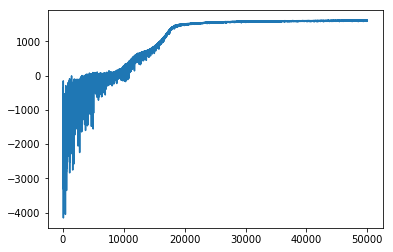

In [46]:
elbo2b = -approx2b.hist
plt.plot(elbo2b);

The ELBO plot demonstrates the convergence.

In [47]:
%%time

t2b = approx2b.approx.sample(10000)

CPU times: user 3.45 s, sys: 396 ms, total: 3.84 s
Wall time: 6.23 s


In [48]:
pm.summary(t2b, varnames=['alpha_pi', 'beta_pi', 'alpha_mu', 'beta_mu', 'alpha_logsigma', 'beta_logsigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha_pi__0,-4.904065,0.083282,0.000822,-5.068060,-4.742210
alpha_pi__1,4.494054,0.087274,0.000833,4.311921,4.656636
alpha_pi__2,0.558275,0.071418,0.000709,0.418681,0.697232
beta_pi__0,8.388446,0.143028,0.001518,8.092629,8.653849
beta_pi__1,-9.742378,0.188759,0.001822,-10.123567,-9.377649
beta_pi__2,-0.240342,0.128723,0.001176,-0.497925,0.002457
alpha_mu__0,0.574240,0.000785,0.000008,0.572751,0.575831
alpha_mu__1,-0.019809,0.000750,0.000007,-0.021301,-0.018358
alpha_mu__2,1.330948,0.002050,0.000022,1.326968,1.334865
beta_mu__0,0.425351,0.001003,0.000010,0.423435,0.427362


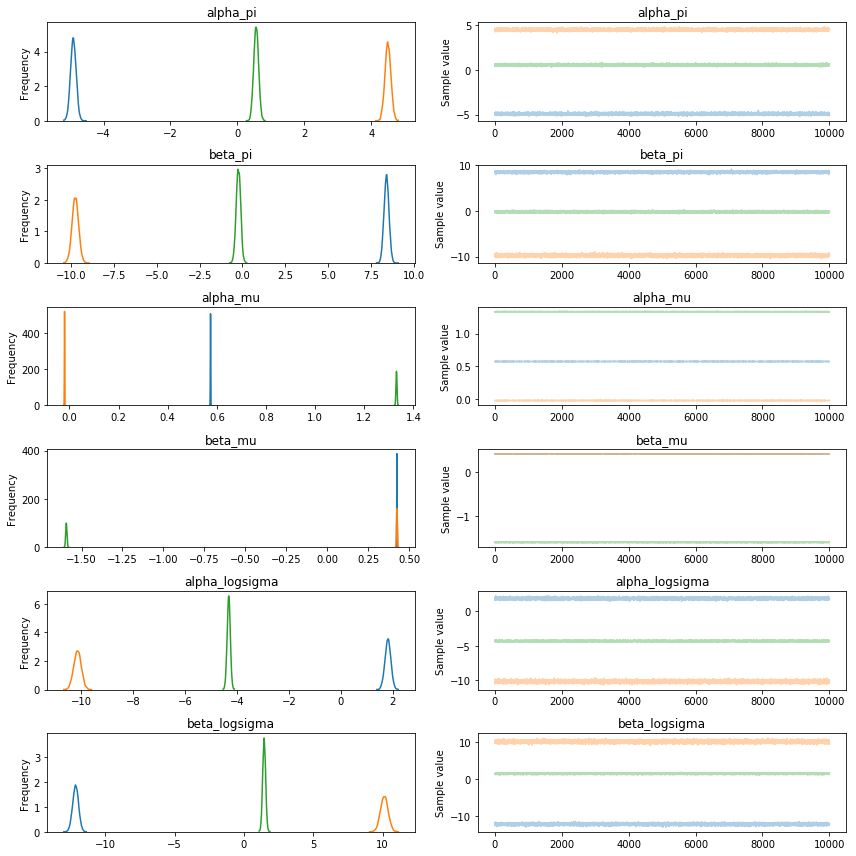

In [49]:
pm.traceplot(t2b, varnames=['alpha_pi', 'beta_pi', 'alpha_mu', 'beta_mu', 'alpha_logsigma', 'beta_logsigma']);

### Answer to Q2 B3

In [50]:
def plot_posteriors(X, post, title=''):
    post_mean = post.mean(axis=0)
    post_std = post.std(axis=0)
    for i in range(post_mean.shape[-1]):
        plt.plot(X, post_mean[:, i])
        plt.fill_between(X, post_mean[:, i]-post_std[:, i], post_mean[:, i]+post_std[:, i], alpha=0.1)
    plt.title(title);

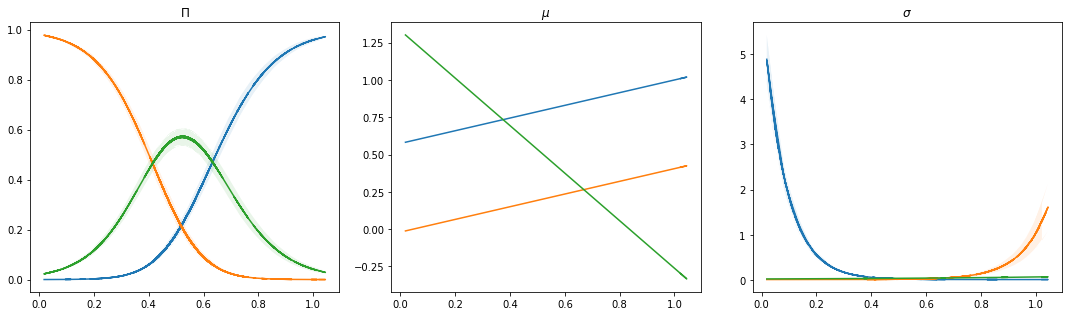

In [51]:
plt.subplots(1, 3, sharex=True, figsize=(15, 4.5))
plt.subplot(1, 3, 1)
plot_posteriors(X_train, t2b['pi'], r'$\Pi$')
plt.subplot(1, 3, 2)
plot_posteriors(X_train, t2b['mu'], r'$\mu$')
plt.subplot(1, 3, 3)
plot_posteriors(X_train, t2b['sigma'], r'$\sigma$')
plt.tight_layout()

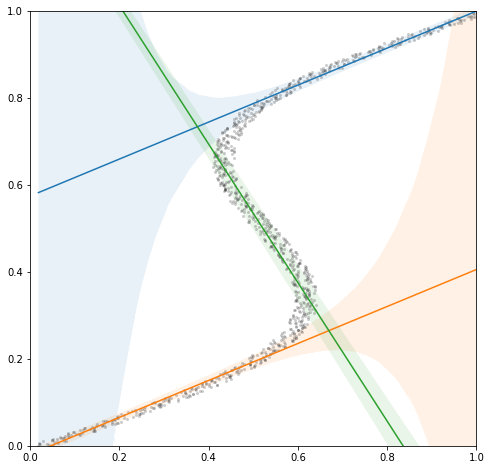

In [52]:
mu_2b = t2b['mu'].mean(axis=0)
sigma_2b = t2b['sigma'].mean(axis=0)
plt.figure(figsize=(8, 8))
for mu_k, sigma_k in zip(mu_2b.T, sigma_2b.T):
    plt.plot(X_train, mu_k)
    plt.fill_between(X_train, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(X_train, y_train, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0, 1]);
plt.ylim([0, 1]);

### Answer to Q2 B4

In [53]:
%%time

with m2b:
    ppc2b = pm.sample_ppc(t2b)

100%|██████████| 10000/10000 [05:09<00:00, 32.28it/s]

CPU times: user 5min 6s, sys: 2.91 s, total: 5min 8s
Wall time: 5min 9s


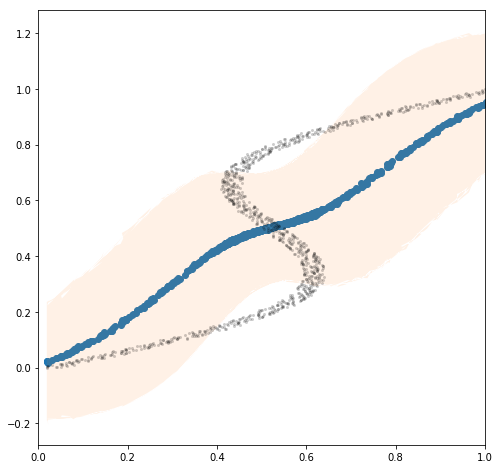

In [54]:
ppc2b_mean = ppc2b['y_obs'].mean(axis=0)
ppc2b_std = ppc2b['y_obs'].std(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(X_train, ppc2b_mean)
plt.fill_between(X_train, ppc2b_mean-ppc2b_std, ppc2b_mean+ppc2b_std, alpha=0.1)
plt.scatter(X_train, y_train, marker='.', lw=0, alpha=0.2, c='black');
plt.xlim([0, 1]);

The posterior predictive looks nothing like the data.

One underlying assumption of mixture of experts is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector. When we sample posterior predictives, we take the average of 3 "expert" gaussians weighted by the probabilities everywhere (**while the correct way should be choosing one expert according to probabilities and use only that expert to predict for a data point**), and the result would thus be off from the data (and meaningless).

### Answer to Q2 B5

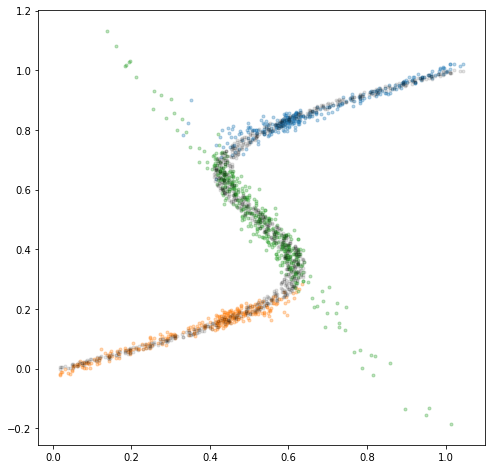

In [55]:
# Reference: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(t2b['pi'].mean(axis=0))

indices = (np.arange(len(X_train)), k)
rn = np.random.randn(len(X_train))
sampled = rn * sigma_2b[indices] + mu_2b[indices]

plt.figure(figsize=(8, 8))

for i in range(3):
    plt.scatter(X_train[k==i], sampled[k==i], alpha=0.3, marker='.');

plt.scatter(X_train, y_train, alpha=0.1, marker='.', color='black');

## Part C. Mixture Density Network

A mixture density network (see the enclosed Chapter 5 excerpt from Bishop or https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) is very closely related to the mixture of experts model. The difference is that we fit the regressions using a neural network where hidden layers are shared amongst the mean, sigma, and mixing probability regressions. (We could have fit 3 separate neural networks in Part A but opted to fit linear regressions for simplicity)

(More explanation [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb). You are welcome to take code from here with attribution.)

You job here is to construct a multi-layer perceptron model with a linear hidden layer with 20 units followed by a `Tanh` activation. After the activation layer, 3 separate linear layers with `n_hidden` inputs and `n_gaussian=3` outputs will complete the network. The probabilities part of the network is then passed through a softmax. The means part is left as is. The sigma part is exponentiated and 0.01 added, as in part A

Thus the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians      ...mu
                            --linear-->n_gaussians->softmax     ...lambda
                            --linear-->n_gaussians->exp + 0.01  ...sigma
```

We then need to use a loss function for the last layer of the network. 

Using the mean-squared-error loss is not appropriate as the expected value of samples drawn from the sampling distribution of the network will not reflect the 3-gaussian structure (this is the essence of the difference between B4 and B5 above). Thus we'll use the negative loss likelihood of the gaussian mixture model explicitly.

**C1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

**C2**: Train the network using the Adam or similiar optimizer. Make sure your loss converges and plot this convergence.

**C3**: Plot the MLE parameters against x. Make a plot similar to B3 above where you overlay the "means" of the gaussians against the data.

**C4**: Sample from the sampling distributions to make a plot similar to B5 above

**To think about but not to hand in** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

### Answer to Q2 C1

In [56]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [57]:
# Reference: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

class MixtureDensityNetwork(nn.Module):
    def __init__(self, n_hidden, n_gaussians=3):
        super(MixtureDensityNetwork, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h)) + 0.01
        mu = self.z_mu(z_h)
        return pi, sigma, mu
    
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

### Answer to Q2 C2

In [58]:
%%time

# Reference: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

X_tensor = torch.from_numpy(np.float32(X_train).reshape(-1, 1))
y_tensor = torch.from_numpy(np.float32(y_train).reshape(-1, 1))
X_variable = Variable(X_tensor)
y_variable = Variable(y_tensor, requires_grad=False)

mdn = MixtureDensityNetwork(n_hidden=20, n_gaussians=3)
optimizer = torch.optim.Adam(mdn.parameters())

max_epoch = 100000
verbose = [2500, 10000]

def train_mdn(max_epoch=max_epoch, verbose=verbose):
    loss_ = []
    for epoch in range(max_epoch):
        pi_variable, sigma_variable, mu_variable = mdn(X_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % verbose[0] == 0 or epoch==max_epoch-1:
            loss_.append(loss.data[0])
        
        if epoch % verbose[1] == 0 or epoch==max_epoch-1:
            print(epoch, loss.data[0])
    return loss_
        
loss_ = train_mdn()

0 0.9405251741409302
10000 -2.042510509490967
20000 -2.1256682872772217
30000 -2.1632397174835205
40000 -2.173300266265869
50000 -2.176223039627075
60000 -2.173076629638672
70000 -2.178365707397461
80000 -2.1789228916168213
90000 -2.179384231567383
99999 -2.175652027130127
CPU times: user 7min 31s, sys: 4.12 s, total: 7min 35s
Wall time: 2min 32s


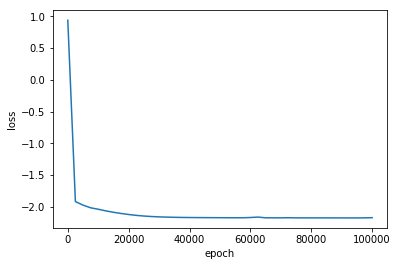

In [59]:
plt.plot(list(range(0, max_epoch, verbose[0]))+[max_epoch-1], loss_);
plt.xlabel('epoch');
plt.ylabel('loss');

As we can see, the model converges (loss becomes stable after 40000 epoches).

### Answer to Q2 C3

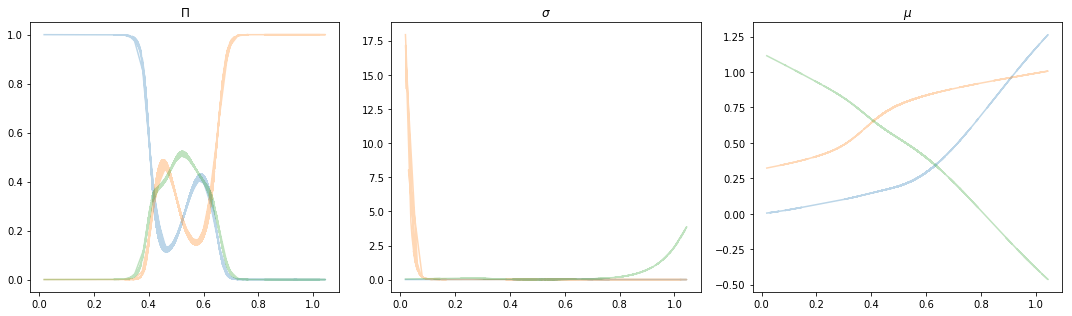

In [60]:
# Reference: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

pi_variable, sigma_variable, mu_variable = mdn(X_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(15, 4.5))
ax1.plot(X_train, pi_data, alpha=0.3)
ax1.set_title('$\Pi$')
ax2.plot(X_train, sigma_data, alpha=0.3)
ax2.set_title('$\sigma$')
ax3.plot(X_train, mu_data, alpha=0.3)
ax3.set_title('$\mu$');
plt.tight_layout();

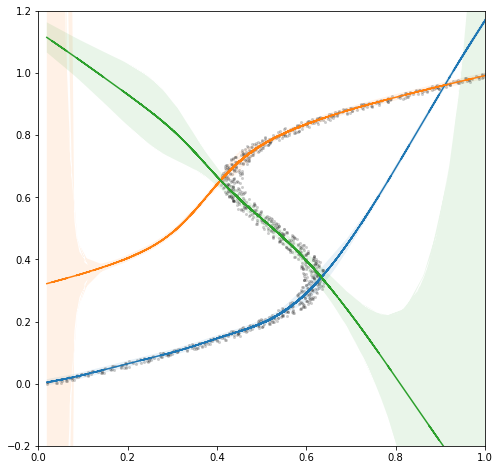

In [61]:
# Reference: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(X_train, mu_k)
    plt.fill_between(X_train, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(X_train, y_train, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0,1])
plt.ylim([-0.2,1.2]);

### Answer to Q2 C4

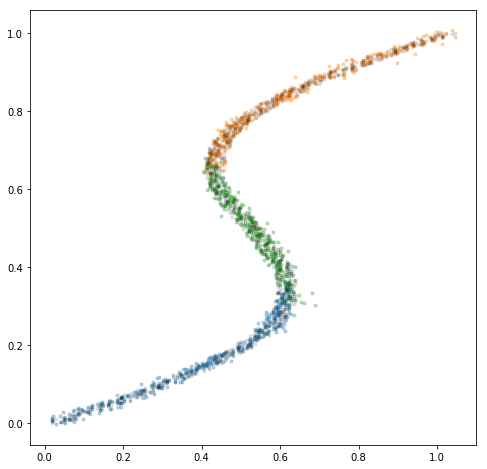

In [62]:
# Reference: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

indices = (np.arange(len(X_train)), k)
rn = np.random.randn(len(X_train))
sampled = rn * sigma_data[indices] + mu_data[indices]

plt.figure(figsize=(8, 8))

for i in range(3):
    plt.scatter(X_train[k==i], sampled[k==i], alpha=0.3, marker='.');

plt.scatter(X_train, y_train, alpha=0.1, marker='.', color='black');

## Part D Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part C in directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**D1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

**D2**: Sample from the posterior predictive as you did in B4 and produce a diagram like C4 and B5 for this model.

**D3**: Plot the "mean" regression curves (similar to C3 and B3). Do the "mean" regression curves in this model look the same from those in Part C?  If they differ why so?

### Answer to Q2 D1

In [63]:
n_gaussians = 3

def construct_MDN(X, y, n_hidden=20, n_gaussians=3, sd=5):
    with pm.Model() as model:
        weights_h = pm.Normal('w_h', 0, sd=sd, shape=(1, n_hidden))
        b_h = pm.Normal('b_h', 0, sd=sd, shape=(1, n_hidden))
        weights_pi = pm.Normal('w_pi', 0, sd=sd, shape=(n_hidden, n_gaussians))
        b_pi = pm.Normal('b_pi', 0, sd=sd, shape=(1, n_gaussians))
        weights_mu = pm.Normal('w_mu', 0, sd=sd, shape=(n_hidden, n_gaussians))
        b_mu = pm.Normal('b_mu', 0, sd=sd, shape=(1, n_gaussians))
        weights_sigma = pm.Normal('w_sigma', 0, sd=sd, shape=(n_hidden, n_gaussians))
        b_sigma = pm.Normal('b_sigma', 0, sd=sd, shape=(1, n_gaussians))
        
        h = pm.math.tanh(pm.math.dot(X, weights_h) + b_h)
        
        pi = pm.Deterministic('pi', T.nnet.softmax(pm.math.dot(h, weights_pi) + b_pi))
        mu = pm.Deterministic('mu', pm.math.dot(h, weights_mu) + b_mu)
        sigma = pm.Deterministic('sigma', pm.math.exp(pm.math.dot(h, weights_sigma) + b_sigma)+0.01)
        
        y_obs = pm.NormalMixture('y_obs', pi, mu, sd=sigma, observed=y)
        
    return model

In [64]:
%%time

m2d = construct_MDN(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
approx2d = pm.ADVI(model=m2d)
approx2d.fit(100000,obj_optimizer=pm.adam(learning_rate=3e-3))

Average Loss = -1,263.4: 100%|██████████| 100000/100000 [05:16<00:00, 315.90it/s]
Finished [100%]: Average Loss = -1,263.1


CPU times: user 5min 6s, sys: 9.38 s, total: 5min 16s
Wall time: 5min 20s


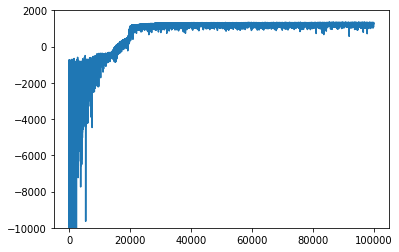

In [65]:
elbo2d = -approx2d.hist
plt.plot(elbo2d);
plt.ylim([-10000,2000]);

The ELBO curve suggests that the algorithm converges.

In [66]:
%%time

t2d = approx2d.approx.sample(10000)

CPU times: user 6.15 s, sys: 216 ms, total: 6.36 s
Wall time: 6.38 s


### Answer to Q2 D2

In [67]:
%%time

with m2d:
    ppc2d = pm.sample_ppc(t2d)

100%|██████████| 10000/10000 [04:39<00:00, 35.83it/s]

CPU times: user 4min 38s, sys: 2.25 s, total: 4min 40s
Wall time: 4min 39s


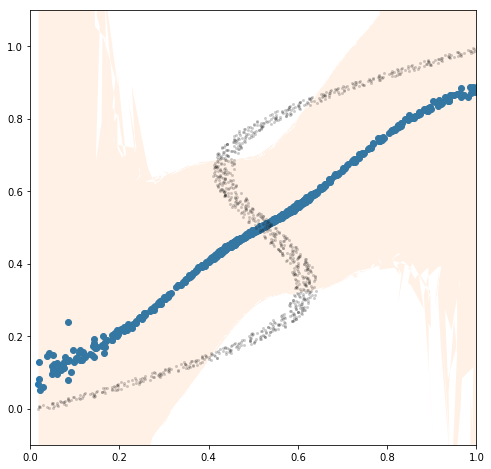

In [68]:
ppc2d_mean = ppc2d['y_obs'].mean(axis=0)
ppc2d_std = ppc2d['y_obs'].std(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(X_train, ppc2d_mean)
plt.fill_between(X_train, ppc2d_mean-ppc2d_std, ppc2d_mean+ppc2d_std, alpha=0.1)
plt.scatter(X_train, y_train, marker='.', lw=0, alpha=0.2, c='black');
plt.xlim([0,1])
plt.ylim([-0.1, 1.1]);

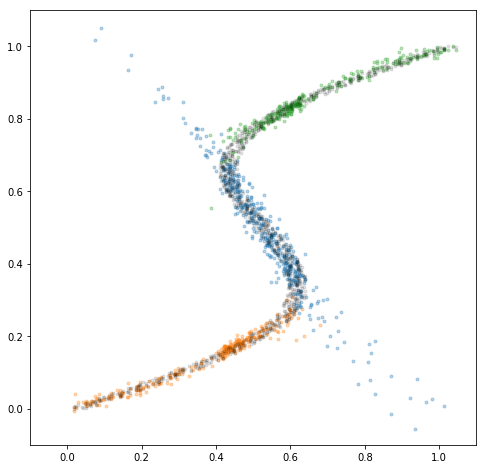

In [69]:
# Reference: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

mu_2d = t2d['mu'].mean(axis=0)
sigma_2d = t2d['sigma'].mean(axis=0)

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(t2d['pi'].mean(axis=0))

indices = (np.arange(len(X_train)), k)
rn = np.random.randn(len(X_train))
sampled = rn * sigma_2d[indices] + mu_2d[indices]

plt.figure(figsize=(8, 8))

for i in range(3):
    plt.scatter(X_train[k==i], sampled[k==i], alpha=0.3, marker='.');

plt.scatter(X_train, y_train, alpha=0.1, marker='.', color='black');
plt.xlim([-0.1, 1.1]);
plt.ylim([-0.1, 1.1]);

### Answer to Q2 D3

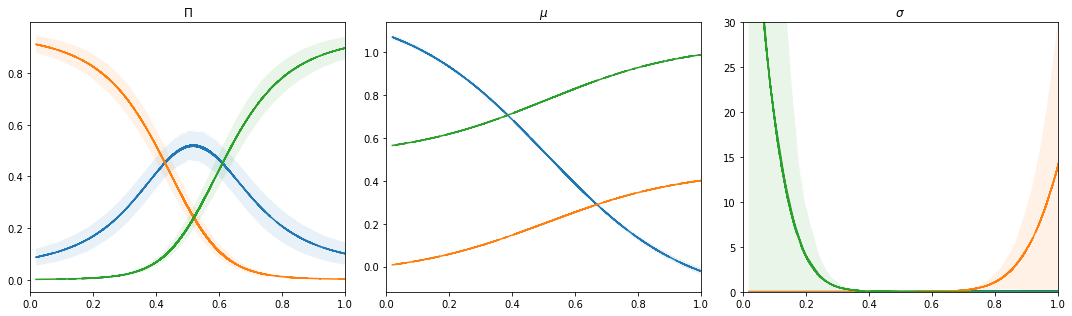

In [70]:
def plot_posteriors(X, post, title=''):
    post_mean = post.mean(axis=0)
    post_std = post.std(axis=0)
    for i in range(post_mean.shape[-1]):
        plt.plot(X, post_mean[:, i])
        plt.fill_between(X, post_mean[:, i]-post_std[:, i], post_mean[:, i]+post_std[:, i], alpha=0.1)
    plt.title(title);
    
plt.subplots(1, 3, sharex=True, figsize=(15,4.5))
plt.subplot(1, 3, 1)
plot_posteriors(X_train, t2d['pi'], r'$\Pi$')
plt.xlim([0, 1])
plt.subplot(1, 3, 2)
plot_posteriors(X_train, t2d['mu'], r'$\mu$')
plt.xlim([0, 1])
plt.subplot(1, 3, 3)
plot_posteriors(X_train, t2d['sigma'], r'$\sigma$')
plt.ylim([0,30])
plt.xlim([0, 1])

plt.tight_layout();

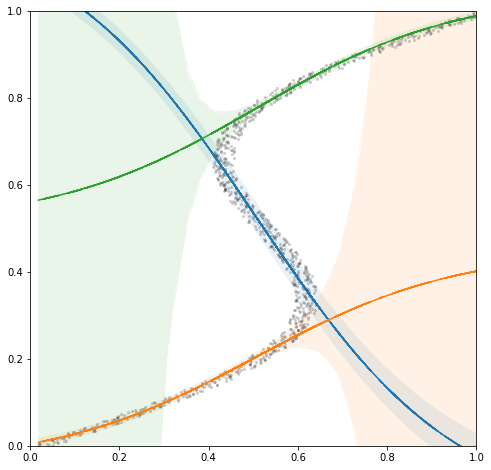

In [71]:
mu_2d = t2d['mu'].mean(axis=0)
sigma_2d = t2d['sigma'].mean(axis=0)
plt.figure(figsize=(8, 8))
for mu_k, sigma_k in zip(mu_2d.T, sigma_2d.T):
    plt.plot(X_train, mu_k)
    plt.fill_between(X_train, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(X_train, y_train, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0, 1]);
plt.ylim([0, 1]);

The "mean" regression curves in this model looks different from those in Part C. Reasons include:
1. The weight priors used in this part are not exactly equivalent to those in Part C. We are essentially adding regularization to the model when we use normal priors (with a finite sd). The results could thus be different.
2. We get different results when we train multiple times for both models, presumably due to the intrinsic stochasticity of the training processes. The model is easily trapped into different local optimums (especially for the pymc3 implementation) even if we use the same set of parameters. Therefore, it is reasonable to get different "mean" regression curves. 

## Part E: Approximate EM for model in part B (EXTRA CREDIT)

Part B can be implemented using Expectation Maximization using iteratively-reweighted least squares. Our method in A was merely an approximation to this process. You can find update equations [here](https://people.eecs.berkeley.edu/~jordan/papers/jordan-xu.ps)

### Answer to Q2 Part E

We use algorithm 1 at the beginning of page 12 of the attached paper *Convergence results for the EM approach to
mixtures of experts architectures*. **To speedup the calculations, we attached a column of 1 to the X so we can combine the slope and intercept calculations.**

The E-step is to calculate $h_j$ (equation 15 in the paper) while the M-step is to update `sigma`, `theta_g` and `theta_j` (note, the paper simplify the $\sigma$ calculations by setting it a single value for each expert). `w_mu` and `b_mu` correspond to $\mathbf{\theta}_j$ (equation 21) in the paper. `theta_g` correspond to $\mathbf{\theta}_0$ in the paper (equation 27).

We notice the algorithm is very sensitive to the initialization of $\theta_j$ and $\theta_g$. It can be easily trapped to some other local optimum. Here we show 2 strategies to enforce the model converge to the expected output; i.e., we can either initialize $\theta_j$ properly or add some constraints to $h_j$ at each iteration.

#### Strategy 1: Initialize $\theta_j$ properly

In [72]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_pdf(y, mu, sigma):
    result = (y - mu) / sigma
    result = -0.5 * (result * result)
    return (np.exp(result)) / sigma * oneDivSqrtTwoPI

def softmax(x):
    result = np.exp(x)
    return result / np.sum(result, axis=1, keepdims=True)
            
def EM(X, y, lr=1e-1, n_gaussians=3, seed=5000, max_iter=1000, thres=1e-5):
    np.random.seed(seed)
    theta_j = np.array([[0.5, -2, 0.5], [0, 1.5, 0.5]])
    theta_g = np.random.randn(X.shape[1], n_gaussians)
    sigma = np.random.rand(n_gaussians) + 0.01
    
    theta_j_old = theta_j
    theta_g_old = theta_g
    sigma_old = sigma
    
    Xy = (X * y.reshape(-1, 1)).reshape(X.shape[0], X.shape[1], 1)
    XXT = np.array([np.outer(x, x) for x in X])
    
    for _ in range(max_iter):    
        # E step
        g = softmax(X.dot(theta_g))
        mu = X.dot(theta_j)
        p = gaussian_pdf(y.reshape(-1, 1), mu, sigma)
        h = g * p
        h = h / np.sum(h, axis=1, keepdims=True)
    
        # M step
        sigma = np.sum(h * np.square(y.reshape(-1, 1)-mu), axis=0) / np.sum(h, axis=0) + 0.01
    
        c = np.tensordot((h / sigma).T, Xy, axes=1)
        R = np.tensordot((h / sigma).T, XXT, axes=1)
    
        theta_j = np.array([np.linalg.solve(R[i], c[i]) for i in range(n_gaussians)]).squeeze().T
    
        eg = np.tensordot((h - g).T, X.reshape(X.shape[0], X.shape[1], 1), axes=1)
        Rg = np.tensordot((g * (1-g)).T, XXT, axes=1)
    
        theta_g = theta_g \
        + lr * np.array([np.linalg.solve(Rg[i], eg[i]) for i in range(n_gaussians)]).squeeze().T
        
        if np.linalg.norm(theta_j - theta_j_old) < thres and np.linalg.norm(theta_g - theta_g_old) < thres \
        and np.linalg.norm(sigma - sigma_old) < thres:
            print('Converge after {} iterations.'.format(_))
            break
            
        theta_j_old = theta_j
        theta_g_old = theta_g
        sigma_old = sigma
            
    return g, X.dot(theta_j), np.array([sigma for _ in range(X.shape[0])])

In [73]:
X_full = np.concatenate((X_train.reshape(-1, 1), np.ones_like(X_train.reshape(-1, 1))), axis=1)

pi_2e, mu_2e, sigma_2e = EM(X_full, y_train)

Converge after 113 iterations.


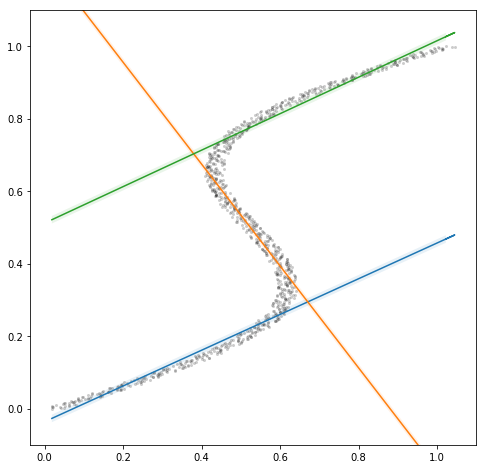

In [74]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_2e.T, sigma_2e.T):
    plt.plot(X_train, mu_k)
    plt.fill_between(X_train, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(X_train, y_train, marker='.', lw=0, alpha=0.2, c='black')
plt.ylim([-0.1,1.1]);

The "mean" regression curves are very similar to those in Part A and Part B (although they have different assumptions for variance).

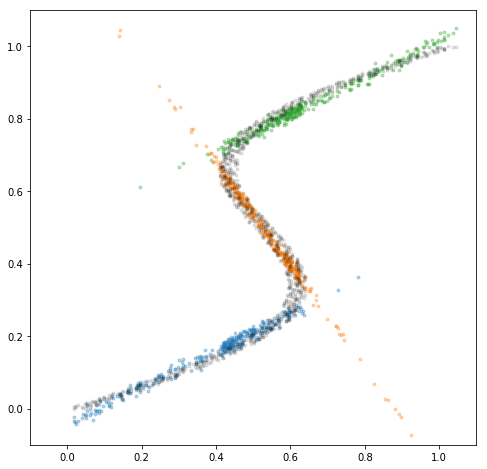

In [75]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_2e)

indices = (np.arange(len(X_train)), k)
rn = np.random.randn(len(X_train))
sampled = rn * sigma_2e[indices] + mu_2e[indices]

plt.figure(figsize=(8, 8))

for i in range(3):
    plt.scatter(X_train[k==i], sampled[k==i], alpha=0.3, marker='.');

plt.scatter(X_train, y_train, alpha=0.1, marker='.', color='black');
plt.xlim([-0.1, 1.1]);
plt.ylim([-0.1, 1.1]);

#### Stategy 2: add constraint to $h_j$ at each iteration

Specifically, we set points $x < 0.2$ with weights $(1,0,0)$ (belongs to cluster 0) and points $x > 0.8$ with weights $(0,0,1)$ (belongs to cluster 2) at each iteration.

In [76]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_pdf(y, mu, sigma):
    result = (y - mu) / sigma
    result = -0.5 * (result * result)
    return (np.exp(result)) / sigma * oneDivSqrtTwoPI

def softmax(x):
    result = np.exp(x)
    return result / np.sum(result, axis=1, keepdims=True)
            
def EM(X, y, lr=1e-1, n_gaussians=3, seed=5000, max_iter=1000, thres=1e-5):
    np.random.seed(seed)
    theta_j = np.random.randn(X.shape[1], n_gaussians)
    theta_g = np.random.randn(X.shape[1], n_gaussians)
    sigma = np.random.rand(n_gaussians) + 0.01
    
    theta_j_old = theta_j
    theta_g_old = theta_g
    sigma_old = sigma
    
    Xy = (X * y.reshape(-1, 1)).reshape(X.shape[0], X.shape[1], 1)
    XXT = np.array([np.outer(x, x) for x in X])
    
    for _ in range(max_iter):    
        # E step
        g = softmax(X.dot(theta_g))
        mu = X.dot(theta_j)
        p = gaussian_pdf(y.reshape(-1, 1), mu, sigma)
        h = g * p
        h = h / np.sum(h, axis=1, keepdims=True)
        h[X[:, 0]<0.2, :] = np.array([[1, 0, 0]])
        h[X[:, 0]>0.8, :] = np.array([[0, 0, 1]])
    
        # M step
        sigma = np.sum(h * np.square(y.reshape(-1, 1)-mu), axis=0) / np.sum(h, axis=0) + 0.01
    
        c = np.tensordot((h / sigma).T, Xy, axes=1)
        R = np.tensordot((h / sigma).T, XXT, axes=1)
    
        theta_j = np.array([np.linalg.solve(R[i], c[i]) for i in range(n_gaussians)]).squeeze().T
    
        eg = np.tensordot((h - g).T, X.reshape(X.shape[0], X.shape[1], 1), axes=1)
        Rg = np.tensordot((g * (1-g)).T, XXT, axes=1)
    
        theta_g = theta_g \
        + lr * np.array([np.linalg.solve(Rg[i], eg[i]) for i in range(n_gaussians)]).squeeze().T
        
        
        
        if np.linalg.norm(theta_j - theta_j_old) < thres and np.linalg.norm(theta_g - theta_g_old) < thres \
        and np.linalg.norm(sigma - sigma_old) < thres:
            print('Converge after {} iterations.'.format(_))
            break
            
        theta_j_old = theta_j
        theta_g_old = theta_g
        sigma_old = sigma
            
    return g, X.dot(theta_j), np.array([sigma for _ in range(X.shape[0])])

In [77]:
X_full = np.concatenate((X_train.reshape(-1, 1), np.ones_like(X_train.reshape(-1, 1))), axis=1)

pi_2e, mu_2e, sigma_2e = EM(X_full, y_train)

Converge after 106 iterations.


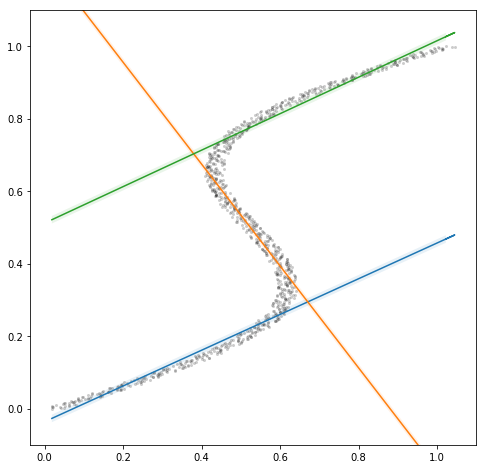

In [78]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_2e.T, sigma_2e.T):
    plt.plot(X_train, mu_k)
    plt.fill_between(X_train, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(X_train, y_train, marker='.', lw=0, alpha=0.2, c='black')
plt.ylim([-0.1,1.1]);

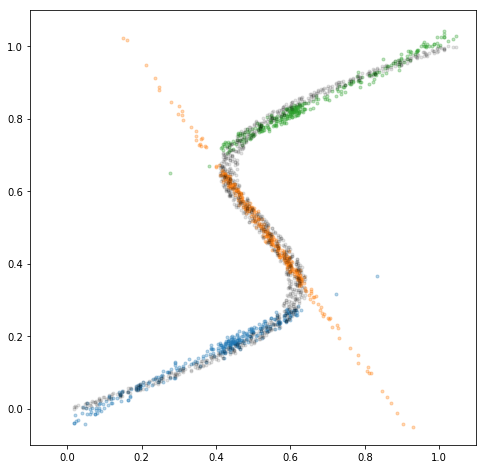

In [79]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_2e)

indices = (np.arange(len(X_train)), k)
rn = np.random.randn(len(X_train))
sampled = rn * sigma_2e[indices] + mu_2e[indices]

plt.figure(figsize=(8, 8))

for i in range(3):
    plt.scatter(X_train[k==i], sampled[k==i], alpha=0.3, marker='.');

plt.scatter(X_train, y_train, alpha=0.1, marker='.', color='black');
plt.xlim([-0.1, 1.1]);
plt.ylim([-0.1, 1.1]);

Both 2 strategies works and we got the correct results.